# Food Company Marketing Campaign Analysis

## Business Insights and Dataset Source

### Business Problem and Description

The food company is planning to launch a direct marketing campaign next month with the goal of maximizing profits. In a pilot campaign with 2,240 customers, those who purchased the offer were labeled as successful. The cost of the pilot campaign was 6,720MU and the revenue from customers who accepted the offer was 3,674MU. Overall, the campaign resulted in a loss of 3,046MU and had a success rate of 15%.

### Objective

The team's goal is to create a model that predicts customer behavior and apply it to the rest of the customer base. Additionally, the Chief Marketing Officer wants to identify the characteristics of customers who are likely to purchase the gadget, in addition to maximizing campaign profits. The plan includes data exploration, segmentation, and building a classification model.

### Dataset Source

Data Sorce : Kaggle [Source Link](https://www.kaggle.com/datasets/jackdaoud/marketing-data)

## Library Setup

In [1]:
# General
import warnings
warnings.filterwarnings('ignore')

# Pandas
import pandas as pd
pd.set_option('display.max_columns',None)

# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Seaborn
import seaborn as sns
sns.set()

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV

# Evaluation
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import (recall_score,
                            precision_score,
                            f1_score,
                            classification_report,
                            roc_auc_score)
from sklearn.metrics import confusion_matrix
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
import scikitplot as skplt

# Statistics Testing
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

## Function Setup

To make data operations more efficient, certain steps and commands are often converted into functions. These functions can be reused multiple times, which simplifies the programming process and reduces the amount of code that needs to be written. By converting these steps into functions, it is easier to perform data operations and streamline the overall process.

### Dataset Information, Feature Checking, and Analysis

In [2]:
def dataInfo(X):
    print('='*10, 'DATA & FEATURE INFORMATION', '='*10)
    print('Data Rows: ', X.shape[0])
    print('Data Columns: ', X.shape[1]) 
    print('Duplicated Values: ', X.duplicated().sum())
    missing_val = X.isnull().sum()
    missing_val_percentage = missing_val/len(X)*100
    data_type = X.dtypes
    unique_val = X.nunique()
    return pd.DataFrame({
        'Missing_val' : missing_val,
        'Missing_percentage' : missing_val_percentage,
        'Data_type' : data_type,
        'Unique_values' : unique_val
    }).sort_values('Missing_percentage',ascending=False)

### Checking Outlier in Data and Returning It

In [3]:
def dataOutlier(X, col):
    q1 = X[col].quantile(0.25) # Finding the first quartile
    q3 = X[col].quantile(0.75) # Finding the third quartile
    iqr_val = stats.iqr(X[col]) # Finding the interquartile range
    lower = q1 - (1.5*iqr_val) # Lower limit for detecting outliers in the data
    upper = q3 + (1.5*iqr_val) # Upper limit for detecting outliers in the data
    
    outlier_list=X[col].apply(lambda x:'outlier' if x<lower or x>upper else 'not-outlier')
    print ('outlier lower limit :',lower, '\noutlier upper limit :', upper)
    return outlier_list

### Returning Unique Values in Data

In [4]:
def dataUnique(X):
    for x in X.columns:
        print('='*10, x, '='*10)
        print(X[x].unique(), '\n') # Printing all the unique values in the columns

### Data Visualization (Used Mostly to See The Data Distribution and Outlier Existence)

In [5]:
def hist_boxplot(df, x_col, y_col=None, hue_col=None):
    color = 'red'
    if y_col is None: 
        plt.figure(figsize=(10,10))
        plt.subplot(211)
        sns.boxplot(data=df, x=x_col, color=color)
        
        plt.subplot(212)
        sns.histplot(data=df, x=x_col, color=color)
        plt.tight_layout()
        plt.show()
        
    elif hue_col is None:
        plt.figure(figsize=(10,10))
        plt.subplot(211)
        sns.boxplot(data=df, x=x_col, y=y_col, color=color)
        
        plt.subplot(212)
        sns.histplot(data=df, x=x_col, y=y_col, color=color)
        plt.tight_layout()
        plt.show()
        
    else:
        plt.figure(figsize=(10,10))
        plt.subplot(211)
        sns.boxplot(data=df, x=x_col, y=y_col, hue=hue_col, color=color)
        
        plt.subplot(212)
        sns.histplot(data=df, x=x_col, y=y_col, hue=hue_col, color=color)
        plt.tight_layout()
        plt.show()

### Another Data Visualization (Used to See The Corelation of Certain Variable, Mostly Between Predictor and Target)

In [6]:
#catergoric vs categoric
#predictor,target
def plot_category_category(df, predictor, target):
    ax = ((df.groupby([predictor])[target].mean())/((df.groupby([predictor])[target].mean()).sum())*100).plot(kind='bar',figsize=(10,8), color = 'r')
    abs_values = round(((df.groupby([predictor])[target].mean())/((df.groupby([predictor])[target].mean()).sum())*100),1)
    ax.bar_label(container=ax.containers[0], labels=abs_values)  

    plt.xticks(rotation=0);
    plt.ylabel('Success Rate (%)',fontsize=12)
    plt.title(f'{predictor} vs Success Rate (%)',fontsize=12)
    plt.xlabel(predictor,fontsize=12)
    plt.ylim(0,100)

    plt.show()

In [7]:
def plot_num_category(df, numeric, category):
    ax = (df.groupby([category])[numeric].median()).plot(kind='bar',figsize=(10,8), color = 'r')
    abs_values = round((df.groupby([category])[numeric].median()),1)
    ax.bar_label(container=ax.containers[0], labels=abs_values)
    
    plt.title(f'{numeric} vs {category}',fontsize=12)
    plt.ylabel(category,fontsize=12)
    plt.xlabel(numeric,fontsize=12)
    plt.xticks(rotation=0);
    plt.ylim(0,max(abs_values)+100)
    plt.show()

## Statistical Analysis (Analysis of Variance and Chi-Square Test)

ANOVA (analysis of variance) is a statistical test that compares the means of multiple groups to determine if there are significant differences between them. The chi-square test is a statistical test that compares observed frequencies in a sample to expected frequencies in a population to determine if there is a significant difference between them. 

ANOVA is used for **continuous data** and assumes normality and equal variances, while the chi-square test is used for **categorical data** and makes no assumptions about the data. ANOVA produces an F-value and p-value, while the chi-square test produces a chi-square statistic and p-value.

In [8]:
def anova(df, predictor_col, target_col):
    group1 = df[df[target_col]==1][predictor_col]
    group2 = df[df[target_col]==0][predictor_col]

    alpha = 0.05
    ftest, p_value = f_oneway(group1, group2)

    if p_value < alpha:
        print(f'Conclusion: p-value {p_value} is less than alpha {alpha}, ftest = {ftest}')
        print('There is a significant difference in the target based on the predictor.')
        print()
    else:
        print(f'Conclusion: p-value {p_value} is greater than alpha {alpha}, ftest = {ftest}')
        print('There is no significant difference in the target based on the predictor.')
        print()

In [9]:
def chi_test(df, predictor_col, target_col):
    obs = pd.crosstab(df[predictor_col], df[target_col])
    chi2, p, dof, expected = chi2_contingency(obs)
    alpha = 0.05

    if p < alpha:
        print(f'===== {predictor_col} =====')
        print('Number Expected:')
        print(expected)
        print()
        print(f'Chi-square Statistic: {chi2}, p-value: {p} less than {alpha}')
        print('There is a significant difference in the target based on the predictor.')
        print()
    else:
        print(f'===== {predictor_col} =====')
        print('Number Expected:')
        print(expected)
        print()
        print(f'Chi-square Statistic: {chi2}, p-value: {p} greater than {alpha}')
        print('There is no significant difference in the target based on the predictor.')
        print()

## Data Preperation

### Import Data

In [10]:
data = pd.read_csv('ifood_df.csv')

In [11]:
data.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,Customer_Days,marital_Divorced,marital_Married,marital_Single,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
0,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,63,2822,0,0,1,0,0,0,0,1,0,0,1529,1441,0
1,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,66,2272,0,0,1,0,0,0,0,1,0,0,21,15,0
2,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,55,2471,0,0,0,1,0,0,0,1,0,0,734,692,0
3,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,36,2298,0,0,0,1,0,0,0,1,0,0,48,43,0
4,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,39,2320,0,1,0,0,0,0,0,0,0,1,407,392,0


### Data Feature Description

| Feature             | Description                                                       | Data Type  |
|---------------------|-------------------------------------------------------------------|------------|
| AcceptedCmp1        | 1 if costumer accepted the offer in the 1st campaign, 0 otherwise |Categorical |
| AcceptedCmp2        | 1 if costumer accepted the offer in the 2nd campaign, 0 otherwise |Categorical |
| AcceptedCmp3        | 1 if costumer accepted the offer in the 3rd campaign, 0 otherwise |Categorical |
| AcceptedCmp4        | 1 if costumer accepted the offer in the 4th campaign, 0 otherwise |Categorical |
| AcceptedCmp5        | 1 if costumer accepted the offer in the 5th campaign, 0 otherwise |Categorical |
| AcceptedCmpOverall  | total of campaign accepted by the costumer                        |Numerical   |
| Response (target)   | 1 if costumer accepted the offer in the last campaign, 0 otherwise|Categorical |
| Complain            | 1 if costumer complained in the last 2 years                      |Categorical |
| Customer_Days       | days of customer's enrollment with the company                    |Numerical   |
| Age                 | customer's age                                                    |Numerical   |
| Education           | customer's level of education                                     |Categorical |
| Marital             | customer's marital status                                         |Categorical |
| Kidhome             | number of small children in customer's household                  |Numerical   |
| Teenhome            | number of teenagers in customer's household                       |Numerical   |
| Income              | customer's yearly household income                                |Numerical   |
| MntFishProducts     | amount spent on fish products in the last 2 years                 |Numerical   |
| MntMeatProducts     | amount spent on meat products in the last 2 years                 |Numerical   |
| MntFruits           | amount spent on fruits in the last 2 years                        |Numerical   |
| MntSweetProducts    | amount spent on sweet products in the last 2 years                |Numerical   |
| MntRegularProds     | amount spent on regular products in the last 2 years              |Numerical   |
| MntWines            | amount spent on wines products in the last 2 years                |Numerical   |
| MntGoldProds        | amount spent on gold products in the last 2 years                 |Numerical   |
| MntTotal            | amount spent on all products in the last 2 years                  |Numerical   |
| NumDealsPurchases   | number of purchases made with discount                            |Numerical   |
| NumCatalogPurchases | number of purchases made using catalogue                          |Numerical   |
| NumStorePurchases   | number of purchases made directly in stores                       |Numerical   |
| NumWebPurchases     | number of purchases made through company's website                |Numerical   |
| NumWebVisitMonth    | number of visit to company's website in the last month            |Numerical   |
| Recency             | number of days since the last purchase                            |Numerical   |
| Z_CostContact       | cost to contact the costumer                                      |Numerical   |
| Z_Revenue           | revenue generated by the costumer                                 |Numerical   |


## Data Checking

### Checking for The Data Dimension, Missing Data, and Wrong Input in Data

In [12]:
dataInfo(data)

========== DATA & FEATURE INFORMATION ==========
Data Rows:  2205
Data Columns:  39
Duplicated Values:  184


,Missing_val,Missing_percentage,Data_type,Unique_values
Income,0,0.0,float64,1963
marital_Together,0,0.0,int64,2
Z_Revenue,0,0.0,int64,1
Response,0,0.0,int64,2
Age,0,0.0,int64,56
Customer_Days,0,0.0,int64,662
marital_Divorced,0,0.0,int64,2
marital_Married,0,0.0,int64,2
marital_Single,0,0.0,int64,2
marital_Widow,0,0.0,int64,2


In [13]:
dataUnique(data)

========== Income ==========
[58138. 46344. 71613. ... 56981. 69245. 52869.] 

========== Kidhome ==========
[0 1 2] 

========== Teenhome ==========
[0 1 2] 

========== Recency ==========
[58 38 26 94 16 34 32 19 68 59 82 53 23 51 20 91 86 41 42 63  0 69 89  4
 96 56 31  8 55 37 76 99  3 88 72 24 92 39 29  2 54 57 30 12 18 75 90  1
 40  9 87  5 95 48 70 79 84 44 43 35 15 17 46 27 25 74 85 65 13 83 10 21
 61 73 47 36 49 28 64 78 77 81 80 45 14 52 98 93 50 60 11 66 97 62  6 33
 22 71 67  7] 

========== MntWines ==========
[ 635   11  426  173  520  235   76   14   28    6  194  233    3 1006
   53   84 1012    4   86    1  867  384  270   36  684    8  112  110
   96  482   40  702   55  437  421   13    9  123  826  245  650   12
  510  328  984  295  447  712  452  523  546  398   10  688  247  856
  496  258  565    2  721 1032  577   64   25  163   17  130  292  350
  135   15   27    5  505   51  207   41  386  562  217  144  454  425
 1332  527  490  378  547   47  320   34  722

### First Observation

1. The dataset consists of 2205 rows and 39 columns. 
2. Some duplicate values are present
3. The columns **Z_CostContact** and **Z_Revenue** can be removed because they have the same value for every row. 
4. The **Kidhome** and **Teenhome** columns can be combined into a single column called **Dependencies** to indicate the number of dependents a person has.

In [14]:
data_new = data.copy()

In [15]:
data_new['Dependencies'] = data_new['Kidhome'] + data_new['Teenhome']

In [16]:
data_new = data_new.drop(['Z_CostContact','Z_Revenue','Kidhome','Teenhome'], axis =1)

In [17]:
data_new.drop_duplicates(keep = 'first', inplace = True)

In [18]:
dataInfo(data_new)

========== DATA & FEATURE INFORMATION ==========
Data Rows:  2021
Data Columns:  36
Duplicated Values:  0


,Missing_val,Missing_percentage,Data_type,Unique_values
Income,0,0.0,float64,1963
Recency,0,0.0,int64,100
Age,0,0.0,int64,56
Customer_Days,0,0.0,int64,662
marital_Divorced,0,0.0,int64,2
marital_Married,0,0.0,int64,2
marital_Single,0,0.0,int64,2
marital_Together,0,0.0,int64,2
marital_Widow,0,0.0,int64,2
education_2n Cycle,0,0.0,int64,2


### Data Descriptive Statistics

In [19]:
numerical = ['Income',
             'Age',
             'Customer_Days',
             'MntTotal',
             'MntRegularProds',
             'MntSweetProducts',
             'Dependencies',
             'Recency',
             'MntWines',
             'MntFruits',
             'MntMeatProducts',
             'MntFishProducts',
             'MntGoldProds',
             'NumDealsPurchases',
             'NumWebPurchases',
             'NumCatalogPurchases',
             'NumStorePurchases',
             'NumWebVisitsMonth',
             'AcceptedCmpOverall']
categorical =['Complain',
              'marital_Divorced',
              'marital_Married',
              'marital_Single',
              'marital_Together',
              'marital_Widow',
              'education_2n Cycle',
              'education_Basic',
              'education_Graduation',
              'education_Master',
              'education_PhD',
              'AcceptedCmp1',
              'AcceptedCmp2',
              'AcceptedCmp3',
              'AcceptedCmp4',
              'AcceptedCmp5']

In [20]:
data_new[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
Income,2021.0,51687.258783,20713.046401,1730.0,35416.0,51412.0,68274.0,113734.0
Age,2021.0,51.117269,11.667616,24.0,43.0,50.0,61.0,80.0
Customer_Days,2021.0,2511.613063,202.546762,2159.0,2337.0,2511.0,2688.0,2858.0
MntTotal,2021.0,563.789213,576.775749,4.0,55.0,343.0,964.0,2491.0
MntRegularProds,2021.0,519.867392,554.797857,-283.0,42.0,288.0,883.0,2458.0
MntSweetProducts,2021.0,27.268679,41.575454,0.0,1.0,8.0,34.0,262.0
Dependencies,2021.0,0.952994,0.746123,0.0,0.0,1.0,1.0,3.0
Recency,2021.0,48.880752,28.950917,0.0,24.0,49.0,74.0,99.0
MntWines,2021.0,306.492331,337.603877,0.0,24.0,178.0,507.0,1493.0
MntFruits,2021.0,26.364671,39.776518,0.0,2.0,8.0,33.0,199.0


### Second Observation

1. The average income of the customers in the dataset is 51687, with a minimum of 1730 and a maximum of 113734. <br>
2. The ages of the customers range from 24 to 80 years old. <br>
3. Most of the customers have been enrolled for between 2159 and 2858 days, or roughly 6 to 8 years. <br>
4. The amount spent on all products and certain specific products in the last 2 years does not appear to have any anomalies, with the exception of the **MntRegularProds** column, which has a minimum value of negative. This column can be modified to only include positive values. <br>
5. There are also no anomalies in the data for the number of purchases and web visits.<br>

In [21]:
data_new[categorical].describe().T

,count,mean,std,min,25%,50%,75%,max
Complain,2021.0,0.009401,0.096527,0.0,0.0,0.0,0.0,1.0
marital_Divorced,2021.0,0.105888,0.307771,0.0,0.0,0.0,0.0,1.0
marital_Married,2021.0,0.388422,0.487512,0.0,0.0,0.0,1.0,1.0
marital_Single,2021.0,0.219198,0.413806,0.0,0.0,0.0,0.0,1.0
marital_Together,2021.0,0.251856,0.434186,0.0,0.0,0.0,1.0,1.0
marital_Widow,2021.0,0.034636,0.182902,0.0,0.0,0.0,0.0,1.0
education_2n Cycle,2021.0,0.090549,0.287038,0.0,0.0,0.0,0.0,1.0
education_Basic,2021.0,0.024245,0.153848,0.0,0.0,0.0,0.0,1.0
education_Graduation,2021.0,0.502227,0.500119,0.0,0.0,1.0,1.0,1.0
education_Master,2021.0,0.165760,0.371957,0.0,0.0,0.0,0.0,1.0


In [22]:
(data_new[data_new[categorical] == 1][categorical].count())/len(data_new)*100

Complain                 0.940129
marital_Divorced        10.588817
marital_Married         38.842157
marital_Single          21.919842
marital_Together        25.185552
marital_Widow            3.463632
education_2n Cycle       9.054923
education_Basic          2.424542
education_Graduation    50.222662
education_Master        16.575952
education_PhD           21.721920
AcceptedCmp1             6.580901
AcceptedCmp2             1.286492
AcceptedCmp3             7.471549
AcceptedCmp4             7.669471
AcceptedCmp5             7.224146
dtype: float64

### Third Observation

1. Less than 1% of the customers in the dataset complained in the past 2 years. 
2. The majority of customers are married and still together, and the majority have completed their graduation.
3. Although the conversion rates for the campaigns range from 1-7%, the third, fourth, and fifth campaigns have the highest success rates of around 7.3-7.4%. 
4. The second campaign has the lowest success rate.

## Exploratory Data Analysis

### Checking The Sucess Rate of The Overall Campaign

In [23]:
successRate = data_new['Response'].value_counts(normalize = True)

([<matplotlib.patches.Wedge at 0x2509be37730>,
 [Text(-0.9739404688821411, 0.5113120016913697, 'failure'),
  Text(0.973940444945898, -0.5113120472848126, 'success')],
 [Text(-0.5312402557538951, 0.2788974554680198, '84.6%'),
  Text(0.5312402426977625, -0.2788974803371705, '15.4%')])

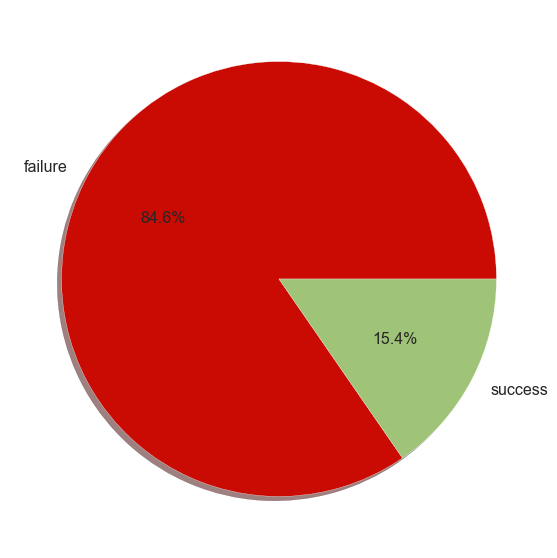

In [24]:
plt.figure(figsize=(10,10))

successRateIndex = successRate.index
count = successRate.values

plt.pie(count, labels=['failure','success'],
        shadow=True,
        colors=['r','g'], 
        autopct='%1.1f%%',
        textprops={'fontsize': 16})

### Profile Analysis of The Costumer

#### 1. Income vs Success Rate

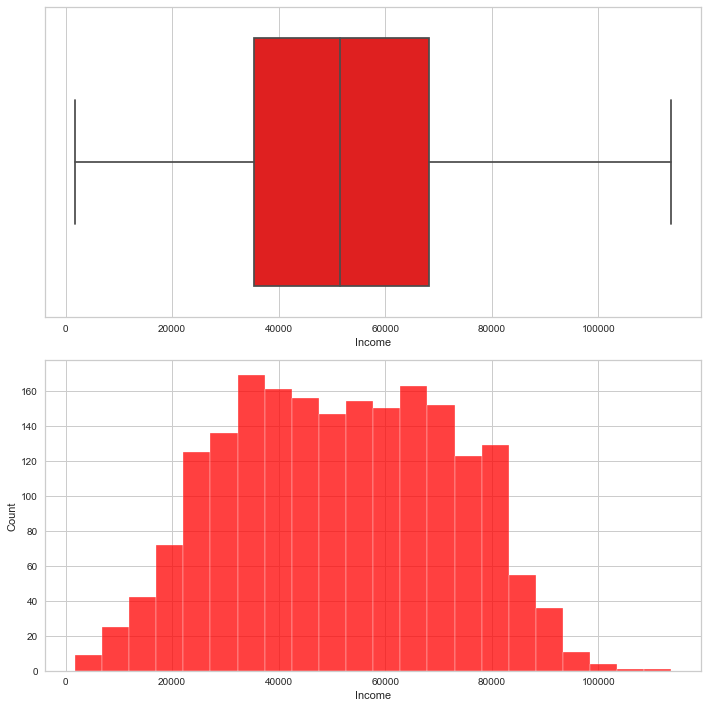

In [25]:
hist_boxplot(data_new,'Income')

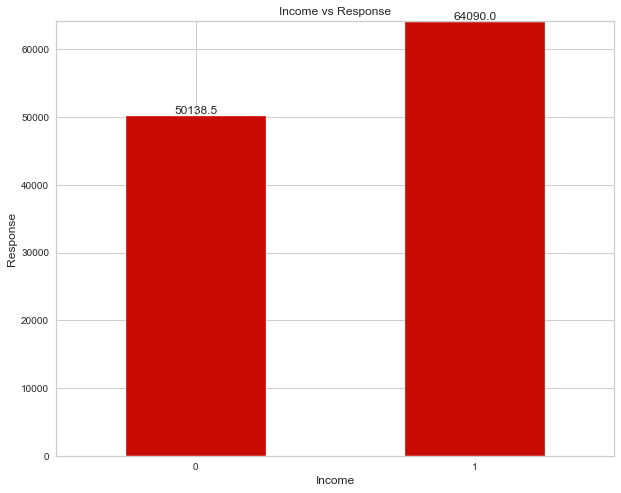

In [26]:
plot_num_category(data_new,'Income','Response')

In [27]:
anova(data_new,'Income','Response')

Conclusion: p-value 2.169272995162176e-15 is less than alpha 0.05, ftest = 63.9111784877772
There is a significant difference in the target based on the predictor.



In [28]:
# Income categorization
# Source : https://money.usnews.com/money/personal-finance/family-finance/articles/where-do-i-fall-in-the-american-economic-class-system
def bin_income (x) :
    if x<=32048 :
        return 'Poor or near-poor'
    elif x<=53413 :
        return 'Lower-middle class'
    elif x<=106827 :
        return 'Middle class'
    elif x<=373894 :
        return 'Upper-middle class'  
    else :
        return 'Rich'

In [29]:
data_new['Income_C'] = data_new['Income'].apply(bin_income)
data_new['Income_C'].unique()

array(['Middle class', 'Lower-middle class', 'Poor or near-poor',
       'Upper-middle class'], dtype=object)

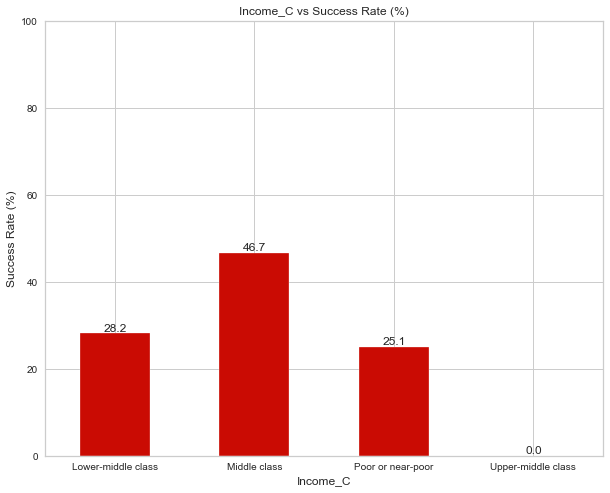

In [30]:
plot_category_category(data_new,'Income_C','Response')

#### Observation and Conclusion

The income data does not contain any outliers. 

Using statistical testing, we can see that there is approximately a 15% difference in median income between customers who responded to the campaign and those who did not. Customers with a balance of 50008 tend to not respond to the campaign, while those with a balance of 64090 tend to respond. 

If we further divide the income data into categories, we can see that middle class customers with incomes between 53413 and 106827 have the highest success rate in the campaign. We can use this data to **target more middle class costumers** for higher success rate.

#### 2. Recency vs Response

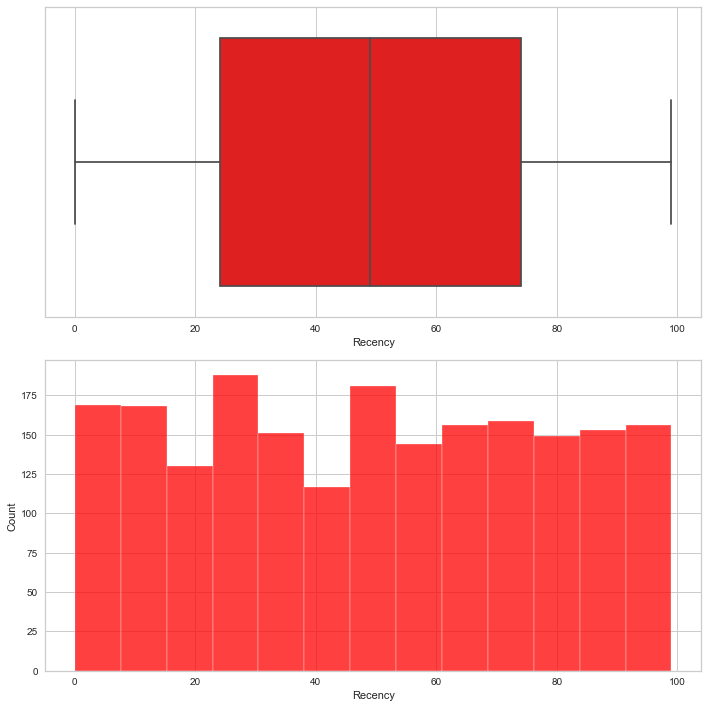

In [31]:
hist_boxplot(data_new,'Recency')

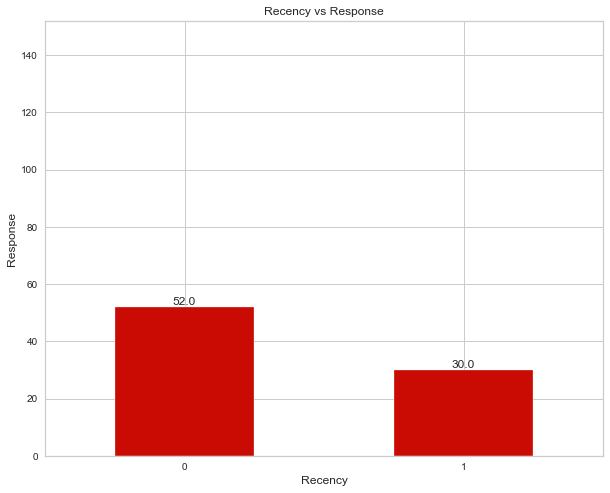

In [32]:
plot_num_category(data_new,'Recency','Response')

In [33]:
anova(data_new,'Recency','Response')

Conclusion: p-value 2.031463417185163e-20 is less than alpha 0.05, ftest = 87.6296210317121
There is a significant difference in the target based on the predictor.



In [34]:
# Recency categorization
def bin_recency (x) :
    if x<=30 :
        return 'Last Month'
    elif x<=60 :
        return 'Last Two Months'
    else :
        return 'More Than Two Months'

In [35]:
data_new['Recency_C'] = data_new['Recency'].apply(bin_recency)
data_new['Recency_C'].unique()

array(['Last Two Months', 'Last Month', 'More Than Two Months'],
      dtype=object)

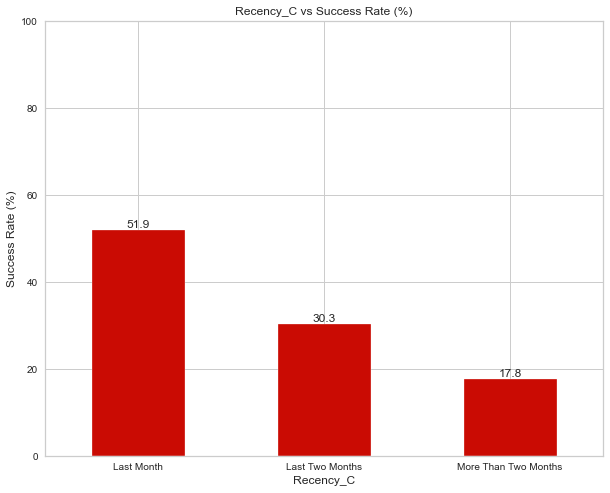

In [36]:
plot_category_category(data_new,'Recency_C','Response')

#### Observation and Conclution

The Recency data does not contain any outliers. 

Through statistical analysis, we find that there is a 10% difference in median Recency between customers who responded to the campaign and those who did not. Customers with a last purchase of 52 days tend to not respond to the campaign, while those with a last purchase of 30 days tend to respond.

By dividing the Recency data into categories, we can see that customers with last purchases within the past month have the highest success rate in the campaign. This trend, known as a recency bias, can be used to **target customers with recent purchases** in future campaigns.

#### 3. Customer_Days vs Response

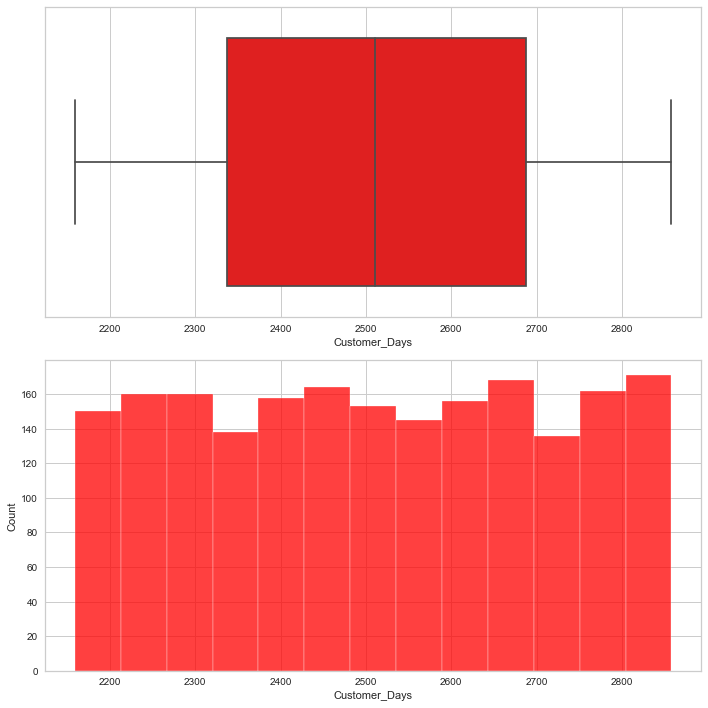

In [37]:
hist_boxplot(data_new,'Customer_Days')

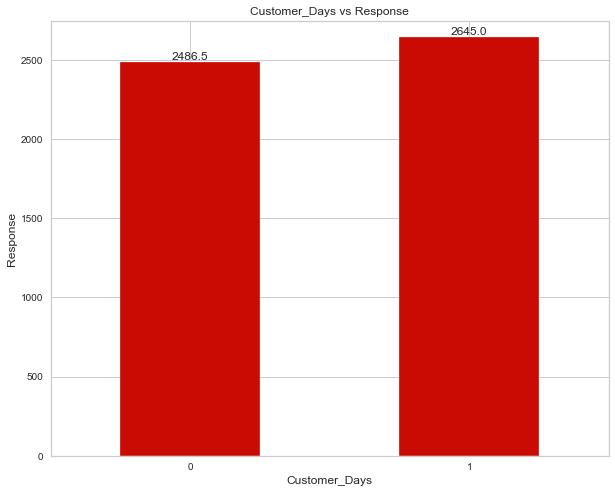

In [38]:
plot_num_category(data_new,'Customer_Days','Response')

In [39]:
anova(data_new,'Customer_Days','Response')

Conclusion: p-value 5.8505450738236644e-18 is less than alpha 0.05, ftest = 75.98401987485839
There is a significant difference in the target based on the predictor.



In [40]:
# Customer Days categorization
def bin_customer_days (x) :
    if x<=365*6 :
        return 'Under 6 years'
    elif x<=365*6.5 :
        return 'Under 6.5 years'
    else :
        return 'More Than 6.5 Years'

In [41]:
data_new['Customer_days_C'] = data_new['Customer_Days'].apply(bin_customer_days)
data_new['Customer_days_C'].unique()

array(['More Than 6.5 Years', 'Under 6.5 years', 'Under 6 years'],
      dtype=object)

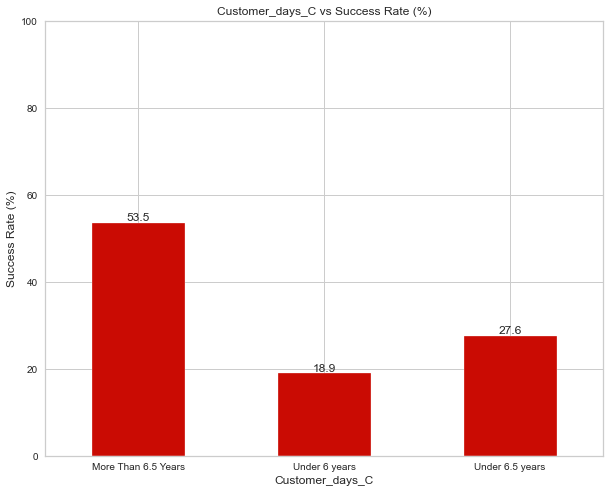

In [42]:
plot_category_category(data_new,'Customer_days_C','Response')

#### Observation and Conclusion

The Customer Days data does not contain any outliers.

Using statistical testing, we can see that there is a small difference in median between customers who responded to the campaign and those who did not. Customers with a Recency of 2490 days tend to not respond to the campaign, while those with a Recency of 2651 days tend to respond.

When we further divide the Recency data into categories, we see that customers who have been enrolled in the company for over 6.5 years have the highest success rate in the campaign. We can use this information to **target more loyal and long-lasting customers** in future campaigns.

#### 4.Age vs Response

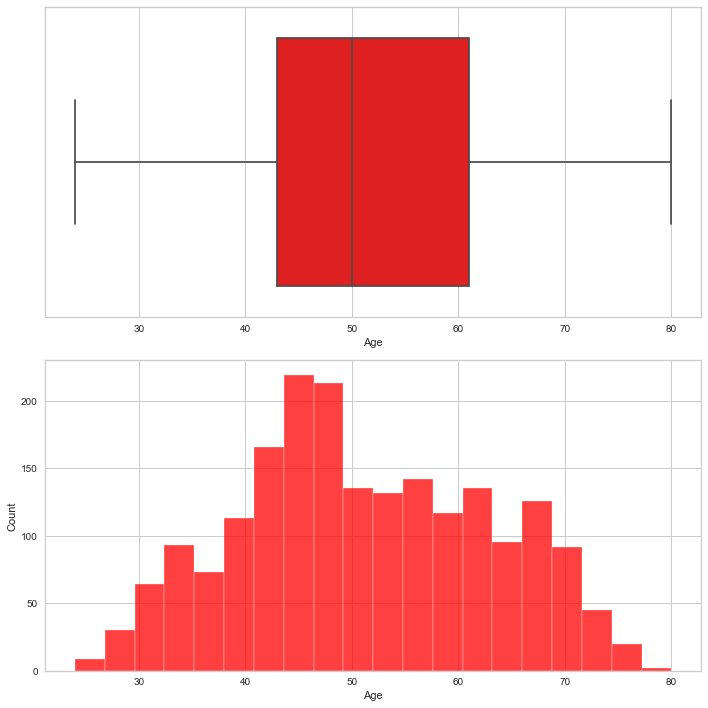

In [43]:
hist_boxplot(data_new,'Age')

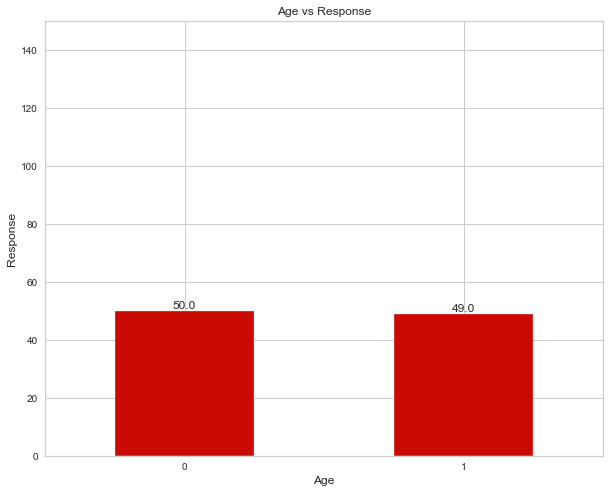

In [44]:
plot_num_category(data_new,'Age','Response')

In [45]:
anova(data_new,'Customer_Days','Response')

Conclusion: p-value 5.8505450738236644e-18 is less than alpha 0.05, ftest = 75.98401987485839
There is a significant difference in the target based on the predictor.



In [46]:
# Customer Days categorization
def bin_age (x) :
    if x<=25 :
        return '25 and lower'
    elif x<=35 :
        return '26-35'
    elif x<=45 :
        return '36-45'
    elif x<=55 :
        return '46-60'
    else :
        return 'More than 61'

In [47]:
data_new['Age_C'] = data_new['Age'].apply(bin_age)
data_new['Age_C'].unique()

array(['More than 61', '46-60', '36-45', '26-35', '25 and lower'],
      dtype=object)

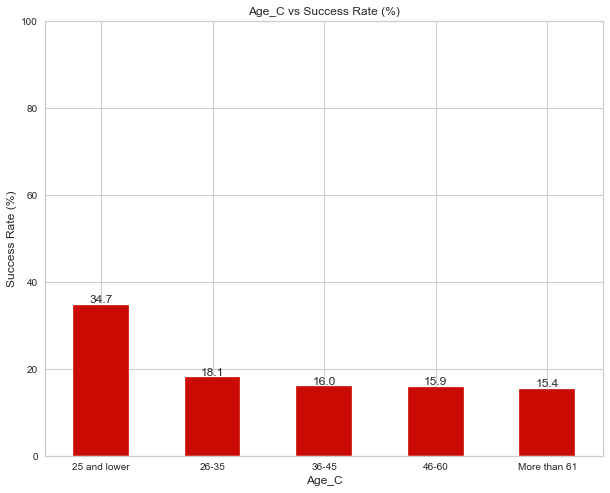

In [48]:
plot_category_category(data_new,'Age_C','Response')

#### Observation and Conclution

The Age data does not contain any outliers.

Using statistical testing, we can see that there is almost no difference in median between customers age who responded to the campaign and those who did not.

When we further divide the Recency data into categories, we see that **customers with age of 25 and lower** have the highest success rate in the campaign. We can use this information to target more customers with that certain age range in future campaigns.

#### 5. Dependencies vs Response

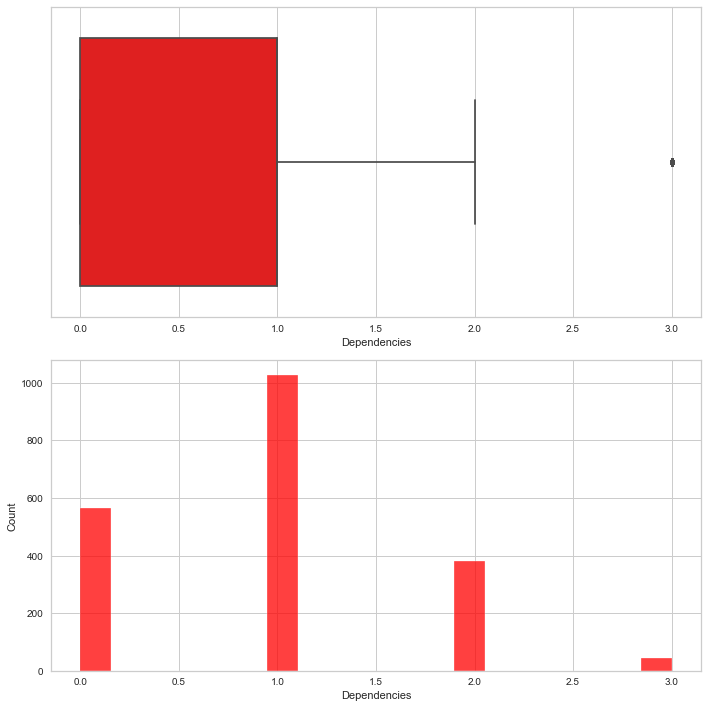

In [49]:
hist_boxplot(data_new,'Dependencies')

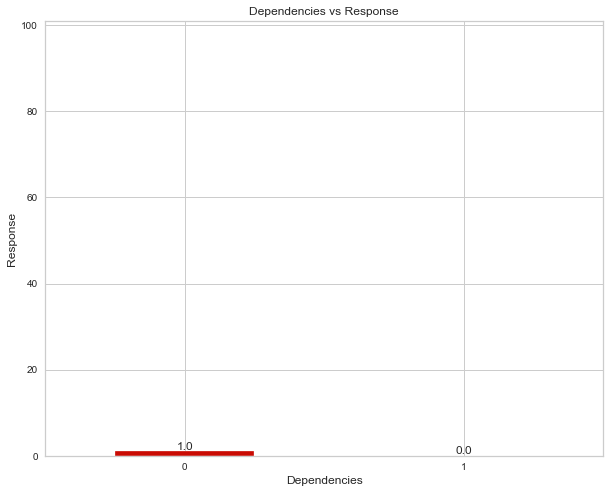

In [50]:
plot_num_category(data_new,'Dependencies','Response')

In [51]:
chi_test(data_new,'Dependencies','Response')

===== Dependencies =====
Number Expected:
[[479.74764968  87.25235032]
 [868.96091044 158.03908956]
 [323.21622959  58.78377041]
 [ 38.07521029   6.92478971]]

Chi-square Statistic: 95.81269587806588, p-value: 1.2349599104969995e-20 less than 0.05
There is a significant difference in the target based on the predictor.



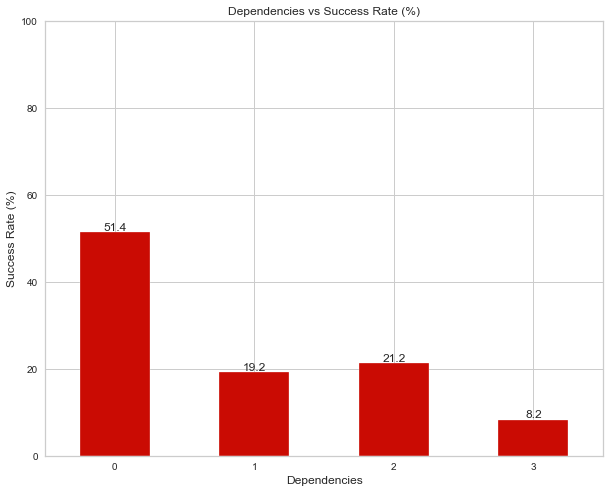

In [52]:
plot_category_category(data_new,'Dependencies','Response')

#### Observation and Conclution

The data contain an outlier but is common to find in this type of data.

We see that customers with no dependencies have the highest success rate in the campaign. We can use this information to target more customers with **no dependencies** in future campaigns.

#### 6. MntTotal vs Response

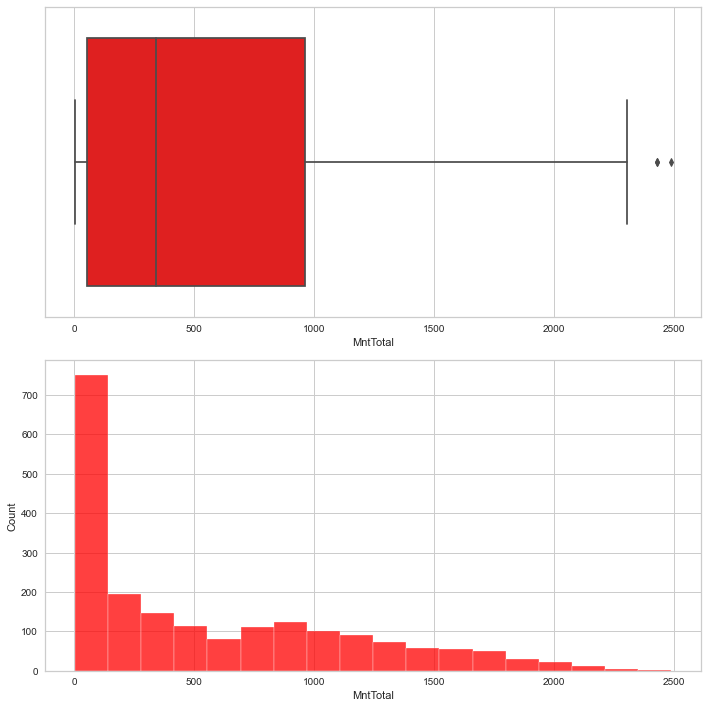

In [53]:
hist_boxplot(data_new,'MntTotal')

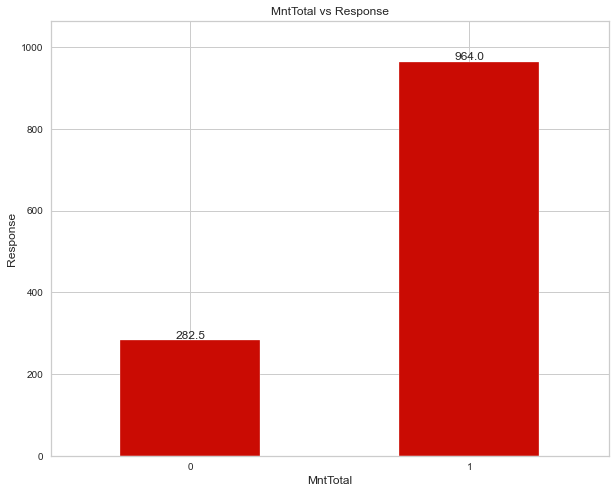

In [54]:
plot_num_category(data_new,'MntTotal','Response')

In [55]:
anova(data_new,'MntTotal','Response')

Conclusion: p-value 6.223332042230628e-33 is less than alpha 0.05, ftest = 148.10190094189875
There is a significant difference in the target based on the predictor.



In [56]:
# Total Purchase categorization
def bin_mnttotal (x) :
    if x<=500 :
        return 'Under 500'
    elif x<=1000 :
        return '501-1000'
    elif x<=1500 :
        return '1001-1500'
    elif x<=2000 :
        return '1501-2000'
    else :
        return 'More Than 2000'

In [57]:
data_new['MntTotal_C'] = data_new['MntTotal'].apply(bin_mnttotal)
data_new['MntTotal_C'].unique()

array(['1501-2000', 'Under 500', '501-1000', '1001-1500',
       'More Than 2000'], dtype=object)

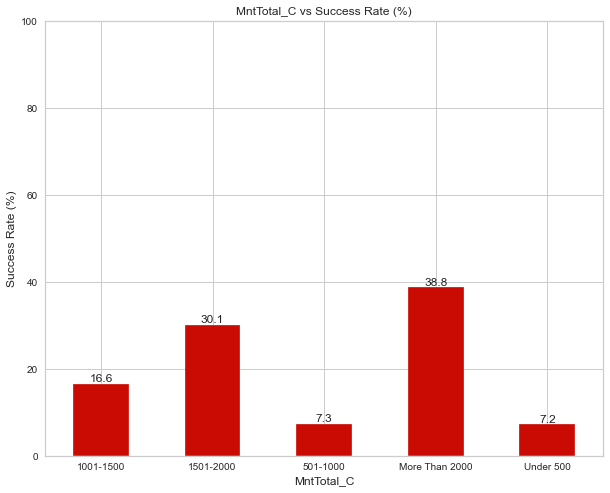

In [58]:
plot_category_category(data_new,'MntTotal_C','Response')

#### Observation and Conclution

The data contain an outlier but is common to find in this type of data.

We see that customers with total purchase in the range of more than 2000 have the highest success rate in the campaign. We can use this information to target more customers with higher spending (above 2000) in future campaigns.

#### 7. NumDealsPurchases vs Response

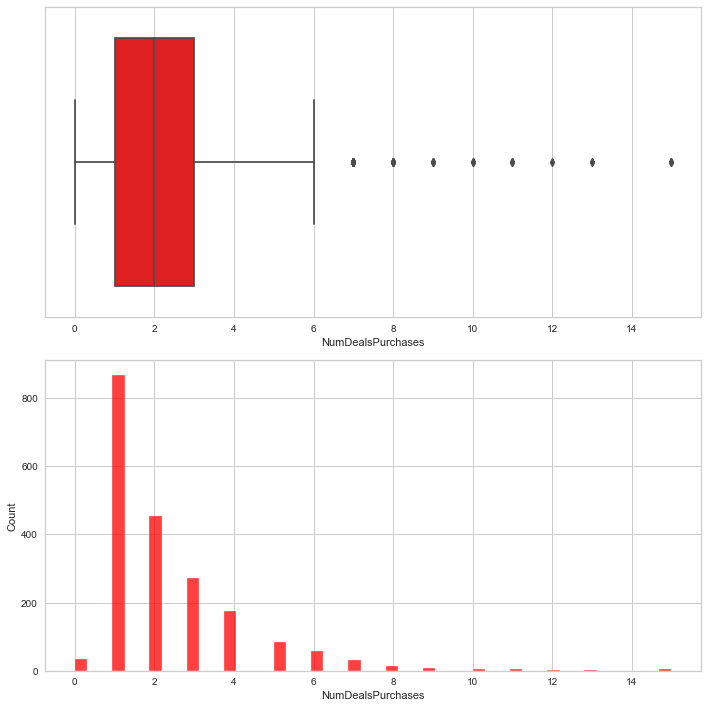

In [59]:
hist_boxplot(data_new,'NumDealsPurchases')

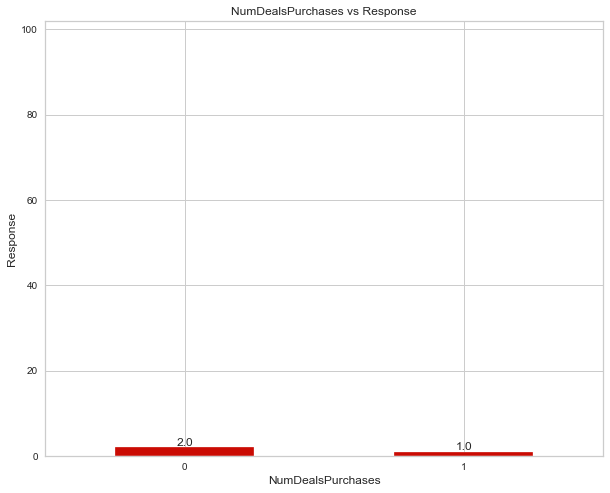

In [60]:
plot_num_category(data_new,'NumDealsPurchases','Response')

In [61]:
anova(data_new,'NumDealsPurchases','Response')

Conclusion: p-value 0.9833560639874191 is greater than alpha 0.05, ftest = 0.0004353139166554931
There is no significant difference in the target based on the predictor.



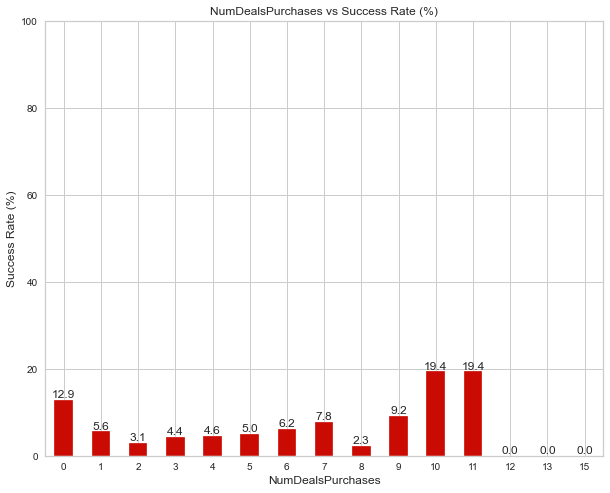

In [62]:
plot_category_category(data_new,'NumDealsPurchases','Response')

#### Observation and Conclution

Number of deals purchased seems to have no strong corelation to the campaign sucess and doesnt have a consistent trend

#### 8. NumWebPurchases vs Response

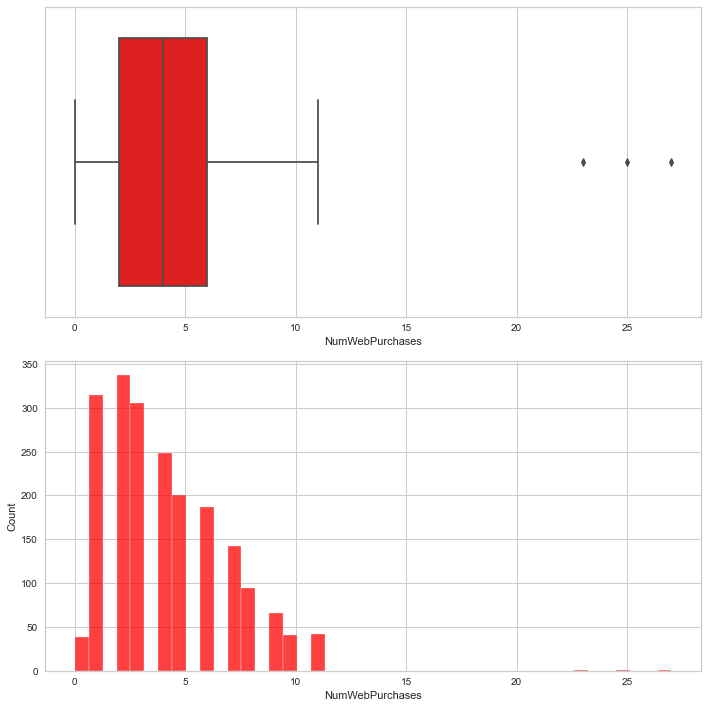

In [63]:
hist_boxplot(data_new,'NumWebPurchases')

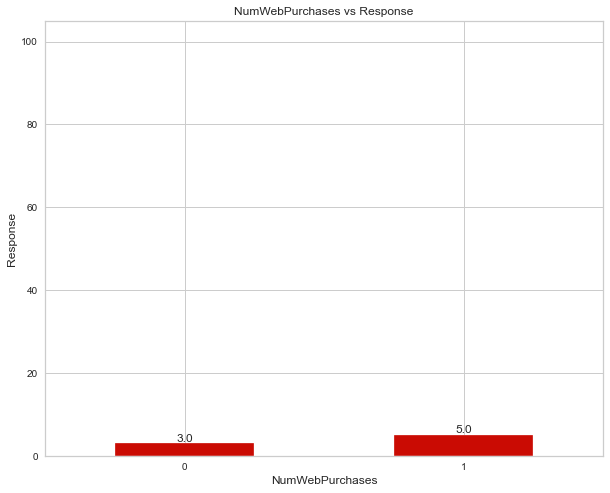

In [64]:
plot_num_category(data_new,'NumWebPurchases','Response')

In [65]:
anova(data_new,'NumWebPurchases','Response')

Conclusion: p-value 4.9314841232941303e-11 is less than alpha 0.05, ftest = 43.6806816063095
There is a significant difference in the target based on the predictor.



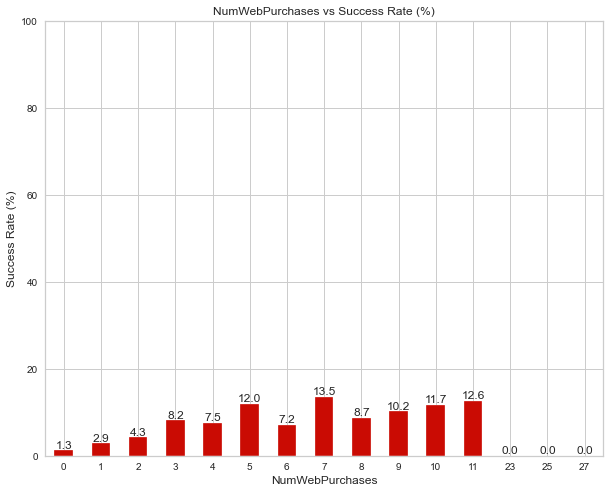

In [66]:
plot_category_category(data_new,'NumWebPurchases','Response')

#### Observation and Conclution

Number of web purchases seems to have corelation to the campaign sucess and have a significant upward trend. From this data, we can utilize the web more as a means of campaign media

#### 9. NumCatalogPurchases vs Response

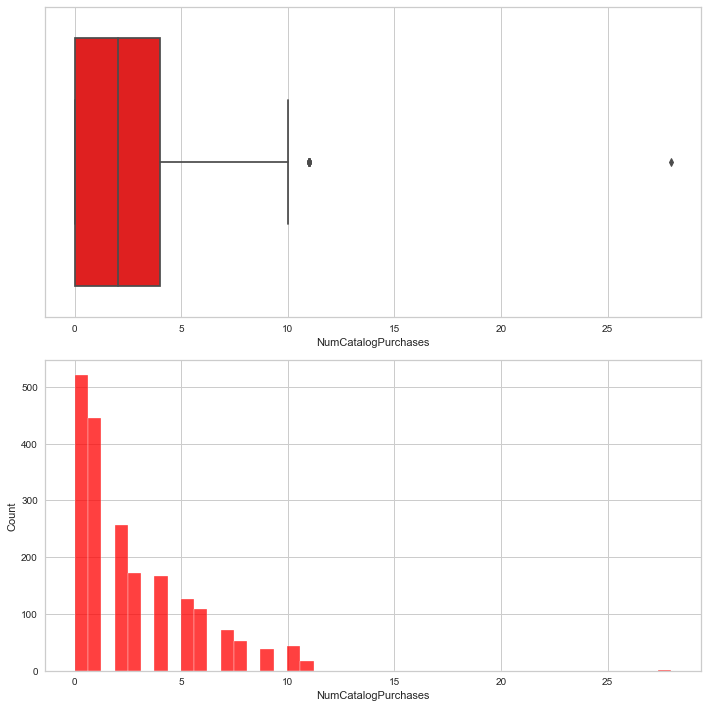

In [67]:
hist_boxplot(data_new,'NumCatalogPurchases')

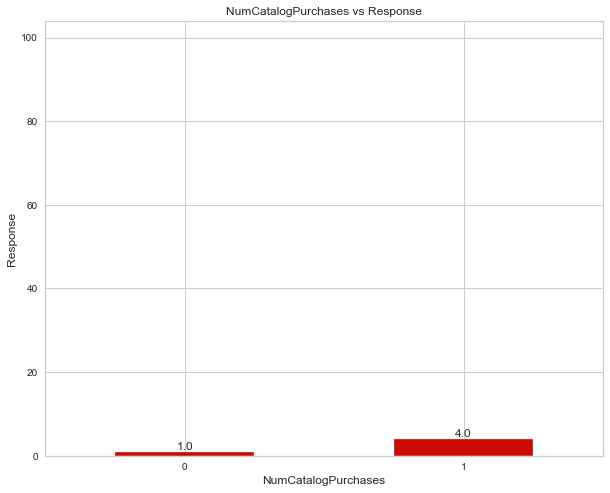

In [68]:
plot_num_category(data_new,'NumCatalogPurchases','Response')

In [69]:
anova(data_new,'NumCatalogPurchases','Response')

Conclusion: p-value 1.5612508436150097e-26 is less than alpha 0.05, ftest = 116.93030545363828
There is a significant difference in the target based on the predictor.



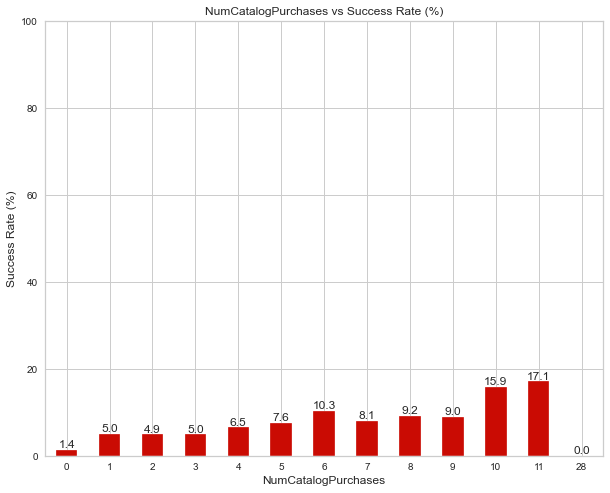

In [70]:
plot_category_category(data_new,'NumCatalogPurchases','Response')

#### Observation and Conclution

Number of catalog purchases seems to have corelation to the campaign sucess and have a significant upward trend. From this data, we can utilize the catalog more as a means of campaign media

#### 10. NumStorePurchases vs Response

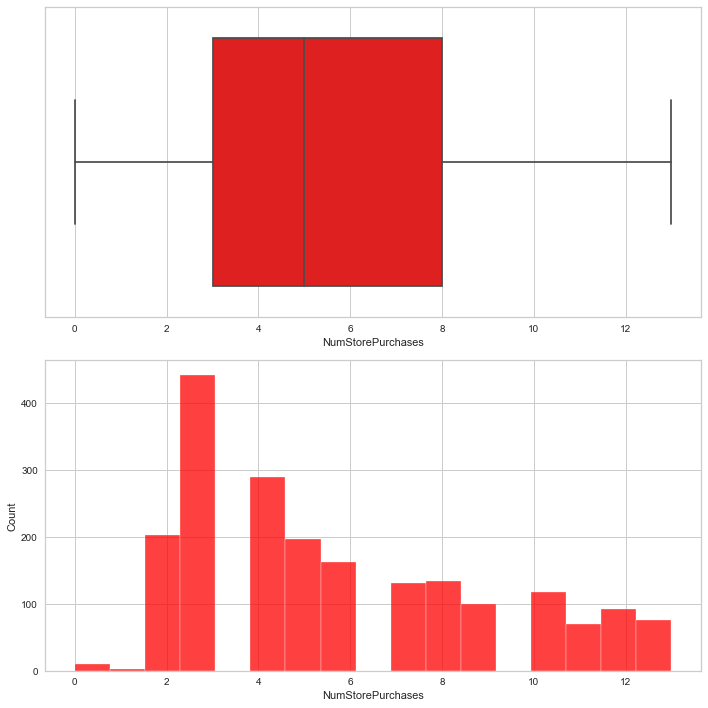

In [71]:
hist_boxplot(data_new,'NumStorePurchases')

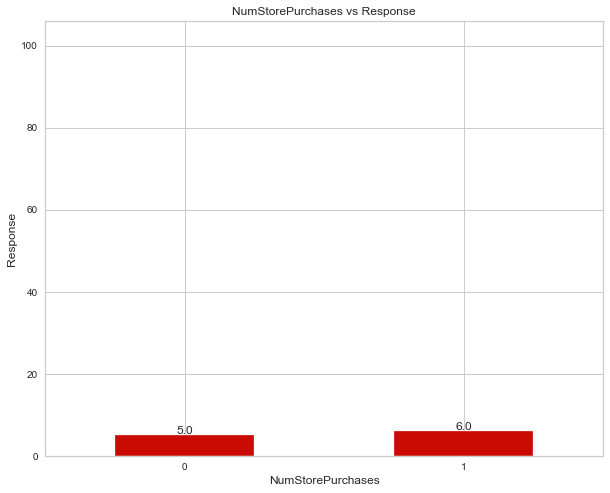

In [72]:
plot_num_category(data_new,'NumStorePurchases','Response')

In [73]:
anova(data_new,'NumStorePurchases','Response')

Conclusion: p-value 0.17636400649333034 is greater than alpha 0.05, ftest = 1.8292805074499936
There is no significant difference in the target based on the predictor.



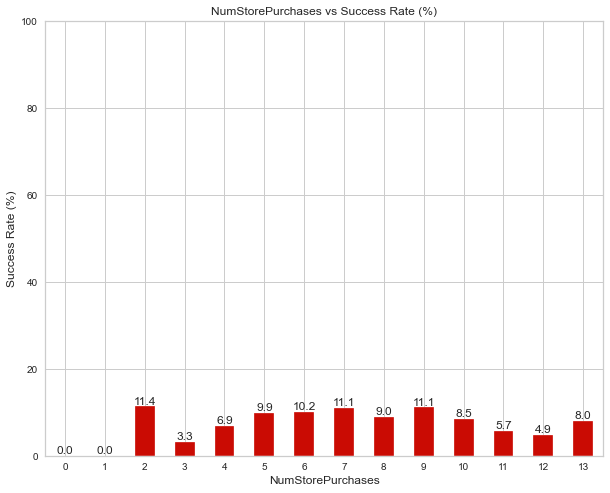

In [74]:
plot_category_category(data_new,'NumStorePurchases','Response')

#### Observation and Conclusion

Number of store purchases seems to have no strong corelation to the campaign sucess and doesnt have a consistent trend

#### 11. NumWebVisitsMonth vs Response

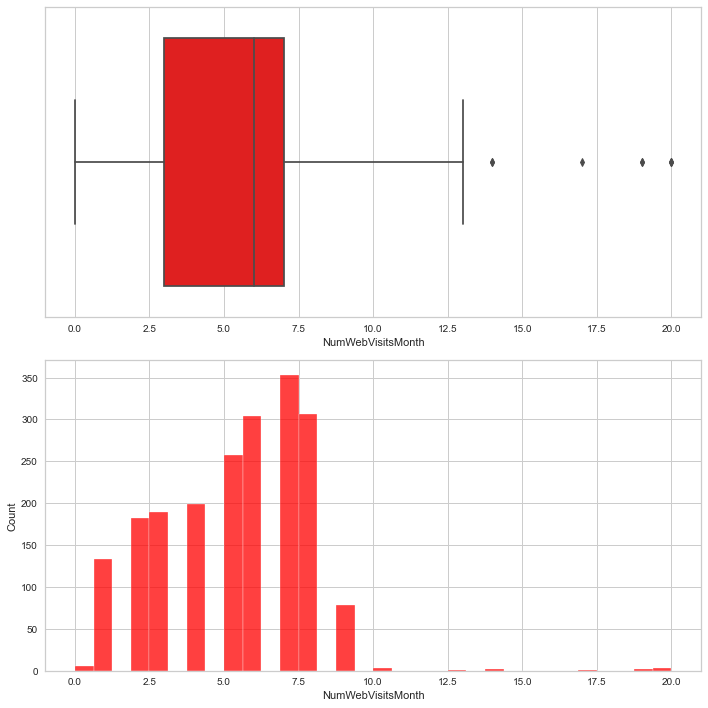

In [75]:
hist_boxplot(data_new,'NumWebVisitsMonth')

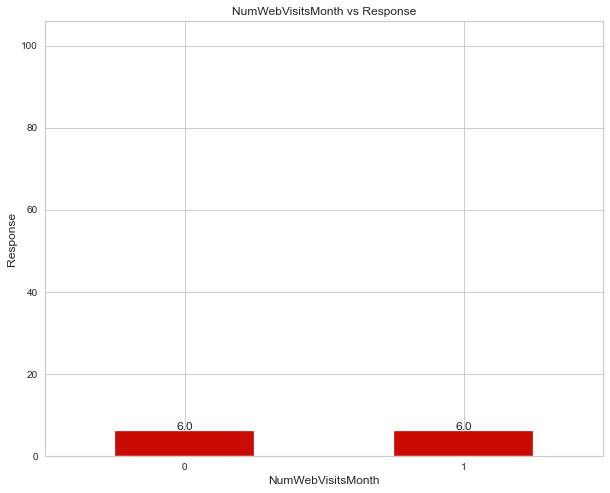

In [76]:
plot_num_category(data_new,'NumWebVisitsMonth','Response')

In [77]:
anova(data_new,'NumWebVisitsMonth','Response')

Conclusion: p-value 0.8020170932374844 is greater than alpha 0.05, ftest = 0.0628858267325062
There is no significant difference in the target based on the predictor.



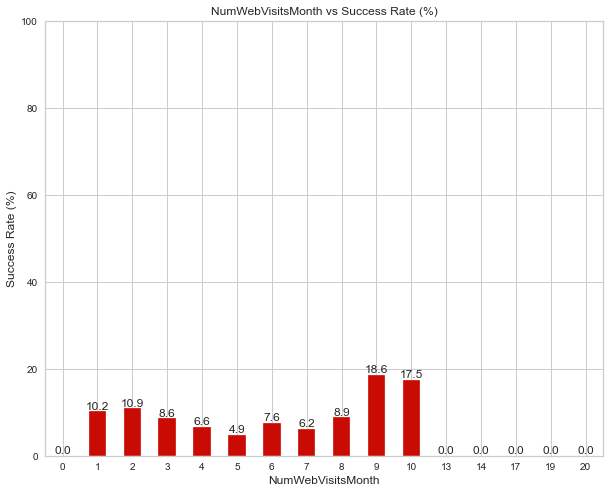

In [78]:
plot_category_category(data_new,'NumWebVisitsMonth','Response')

#### Observation and Conclusion

Number of web visit seems to have no strong corelation to the campaign sucess and doesnt have a consistent trend

#### 12. NumWebVisitsMonth vs NumWebPurchases

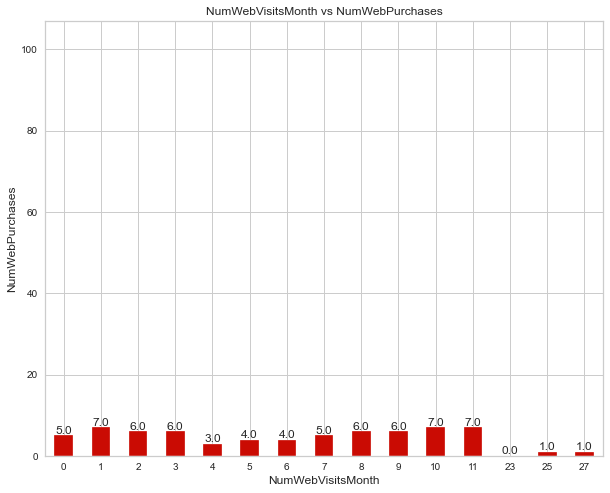

In [79]:
plot_num_category(data_new,'NumWebVisitsMonth','NumWebPurchases')

In [80]:
anova(data_new,'NumWebVisitsMonth','NumWebPurchases')

Conclusion: p-value 0.14666061675471886 is greater than alpha 0.05, ftest = 2.1159984511898307
There is no significant difference in the target based on the predictor.



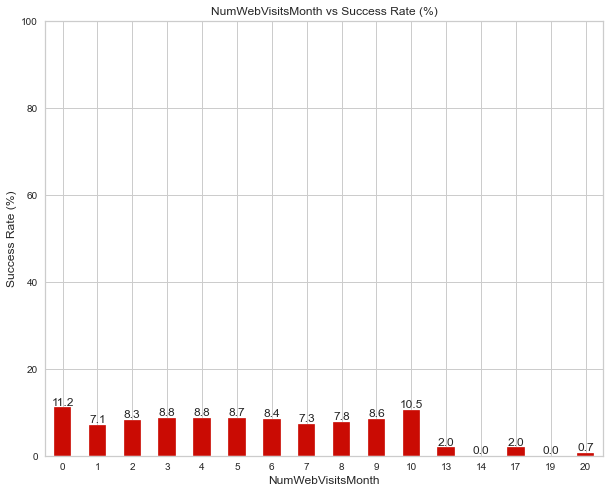

In [81]:
plot_category_category(data_new,'NumWebVisitsMonth','NumWebPurchases')

#### Observation and Conclusion

Number of web visit seems to have no strong corelation to the web purchases and doesnt have a consistent trend

#### 13. Complain vs Response

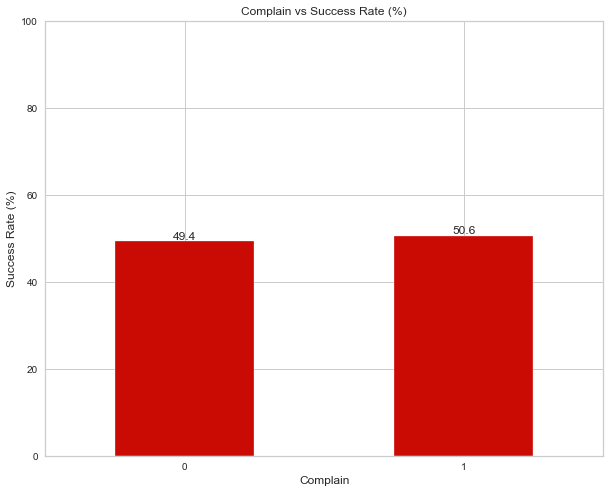

In [82]:
plot_category_category(data_new,'Complain','Response')

In [83]:
chi_test(data_new,'Complain','Response')

===== Complain =====
Number Expected:
[[1693.9238001  308.0761999]
 [  16.0761999    2.9238001]]

Chi-square Statistic: 0.0, p-value: 1.0 greater than 0.05
There is no significant difference in the target based on the predictor.



#### Observation and Conclusion

Number of complains in the last 2 years seems to have no strong corelation to the campaign success

#### 14. marital_Divorced vs Response

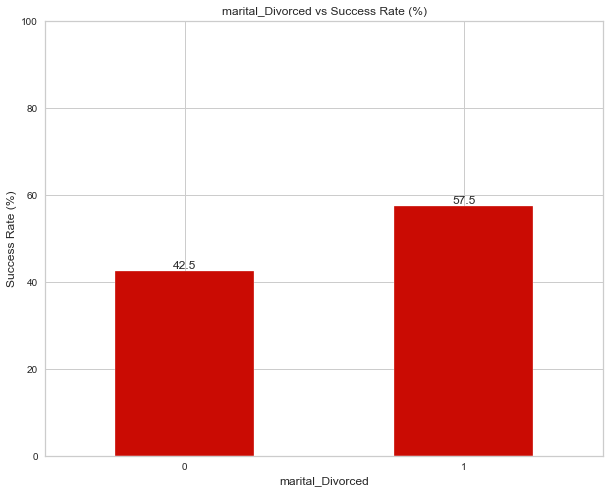

In [84]:
plot_category_category(data_new,'marital_Divorced','Response')

In [85]:
chi_test(data_new,'marital_Divorced','Response')

===== marital_Divorced =====
Number Expected:
[[1528.93122217  278.06877783]
 [ 181.06877783   32.93122217]]

Chi-square Statistic: 3.675220986316271, p-value: 0.05522693221675212 greater than 0.05
There is no significant difference in the target based on the predictor.



#### Observation and Conclusion

Divorced customers tends to accept or response the campaign

#### 15. marital_Married vs Response

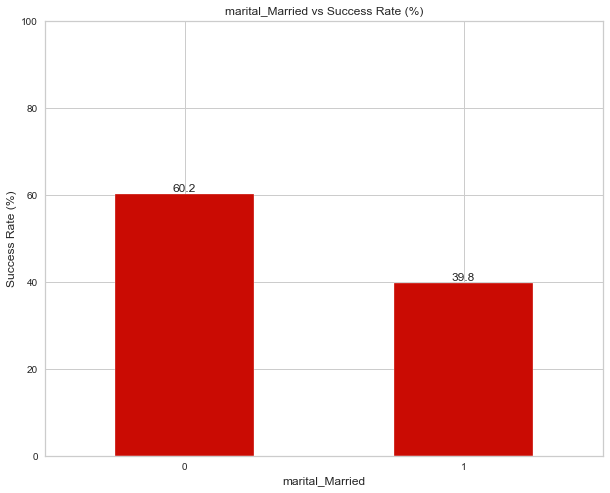

In [86]:
plot_category_category(data_new,'marital_Married','Response')

In [87]:
chi_test(data_new,'marital_Married','Response')

===== marital_Married =====
Number Expected:
[[1045.79910935  190.20089065]
 [ 664.20089065  120.79910935]]

Chi-square Statistic: 12.811496087821242, p-value: 0.00034449598195964896 less than 0.05
There is a significant difference in the target based on the predictor.



#### Observation and Conclusion

Married customers tends to not accept or response the campaign

#### 16. marital_Single vs Response

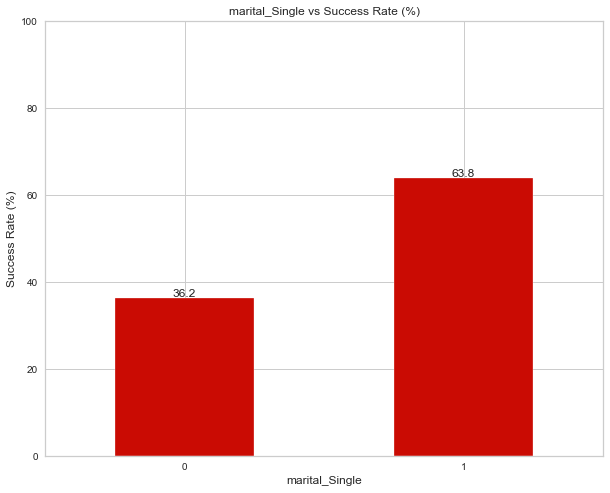

In [88]:
plot_category_category(data_new,'marital_Single','Response')

In [89]:
chi_test(data_new,'marital_Single','Response')

===== marital_Single =====
Number Expected:
[[1335.17070757  242.82929243]
 [ 374.82929243   68.17070757]]

Chi-square Statistic: 26.167451044572047, p-value: 3.1305507304621226e-07 less than 0.05
There is a significant difference in the target based on the predictor.



#### Observation and Conclusion

Single customers tends to accept or response the campaign

#### 17. marital_Together vs Response

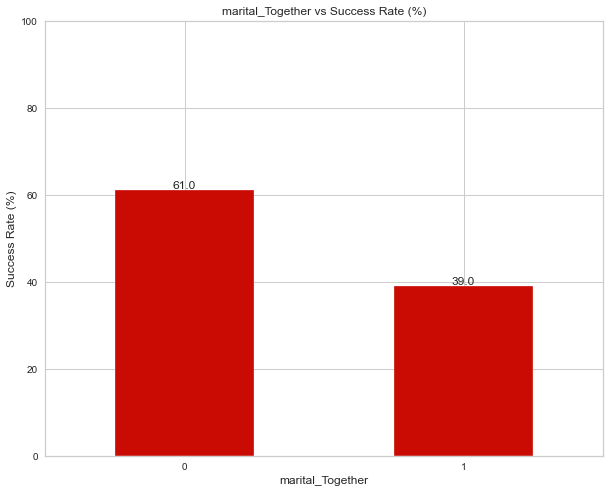

In [90]:
plot_category_category(data_new,'marital_Together','Response')

In [91]:
chi_test(data_new,'marital_Together','Response')

===== marital_Together =====
Number Expected:
[[1279.32706581  232.67293419]
 [ 430.67293419   78.32706581]]

Chi-square Statistic: 10.509282086047413, p-value: 0.0011877639228977132 less than 0.05
There is a significant difference in the target based on the predictor.



#### Observation and Conclusion

Customers that are together tends not to accept or response the campaign

#### 18. marital_Widow vs Response

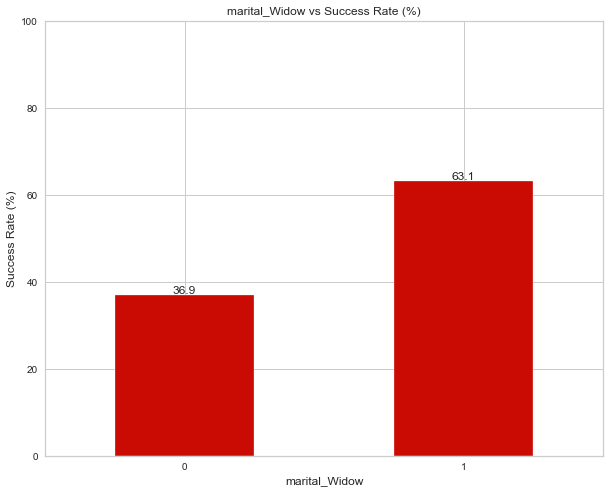

In [92]:
plot_category_category(data_new,'marital_Widow','Response')

In [93]:
chi_test(data_new,'marital_Widow','Response')

===== marital_Widow =====
Number Expected:
[[1650.7718951  300.2281049]
 [  59.2281049   10.7718951]]

Chi-square Statistic: 5.144849080653362, p-value: 0.023315436961919966 less than 0.05
There is a significant difference in the target based on the predictor.



#### Observation and Conclusion

Widow customers tends to accept or response the campaign

#### 19. education_2n Cycle vs Response

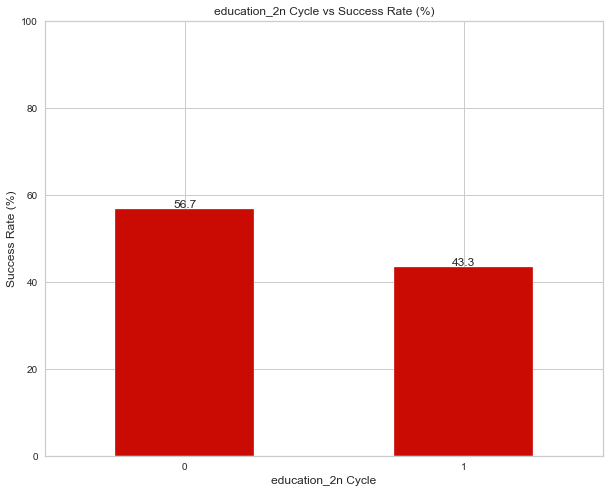

In [94]:
plot_category_category(data_new,'education_2n Cycle','Response')

In [95]:
chi_test(data_new,'education_2n Cycle','Response')

===== education_2n Cycle =====
Number Expected:
[[1555.16081148  282.83918852]
 [ 154.83918852   28.16081148]]

Chi-square Statistic: 1.4787788421243775, p-value: 0.2239656815533361 greater than 0.05
There is no significant difference in the target based on the predictor.



#### Observation and Conclusion

education_2n Cycle tends to not accept or response the campaign

#### 20. education_Basic vs Response

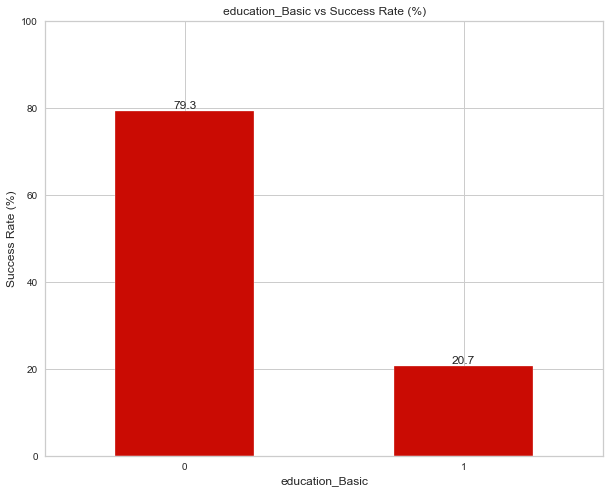

In [96]:
plot_category_category(data_new,'education_Basic','Response')

In [97]:
chi_test(data_new,'education_Basic','Response')

===== education_Basic =====
Number Expected:
[[1668.54032657  303.45967343]
 [  41.45967343    7.54032657]]

Chi-square Statistic: 4.080907984586685, p-value: 0.043370347073790665 less than 0.05
There is a significant difference in the target based on the predictor.



#### Observation and Conclusion

education_Basic tends to not accept or response more the campaign

#### 21. education_Graduation vs Response

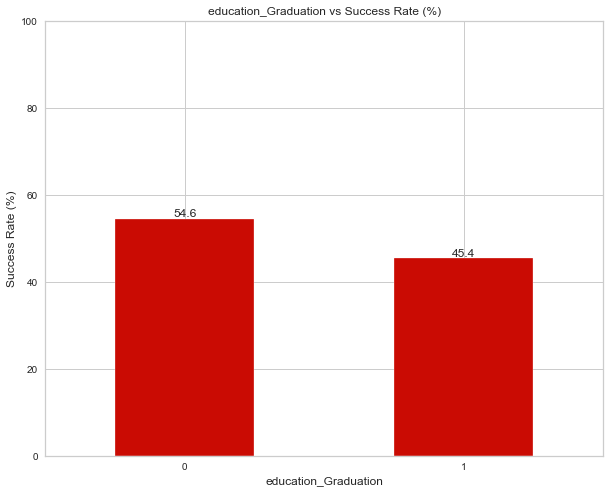

In [98]:
plot_category_category(data_new,'education_Graduation','Response')

In [99]:
chi_test(data_new,'education_Graduation','Response')

===== education_Graduation =====
Number Expected:
[[851.19247897 154.80752103]
 [858.80752103 156.19247897]]

Chi-square Statistic: 2.8499850598578123, p-value: 0.09137478586788461 greater than 0.05
There is no significant difference in the target based on the predictor.



#### Observation and Conclusion

education_Graduation seems to have no corelation

#### 22. education_Master vs Response

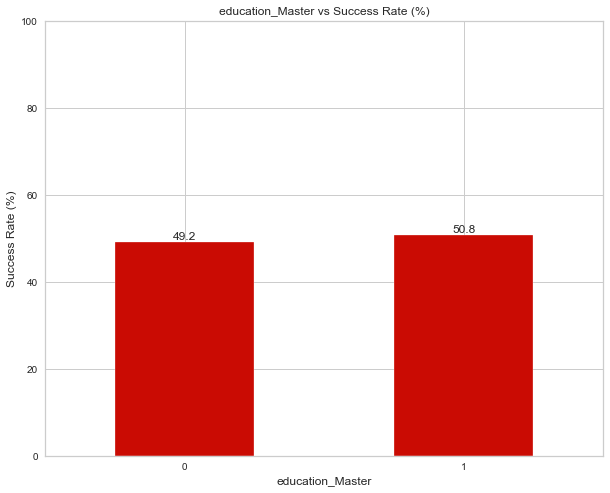

In [100]:
plot_category_category(data_new,'education_Master','Response')

In [101]:
chi_test(data_new,'education_Master','Response')

===== education_Master =====
Number Expected:
[[1426.55121227  259.44878773]
 [ 283.44878773   51.55121227]]

Chi-square Statistic: 0.02473877450579027, p-value: 0.8750197321182948 greater than 0.05
There is no significant difference in the target based on the predictor.



#### Observation and Conclusion

education_Master seems to have no corelation

#### 23. education_PhD vs Response

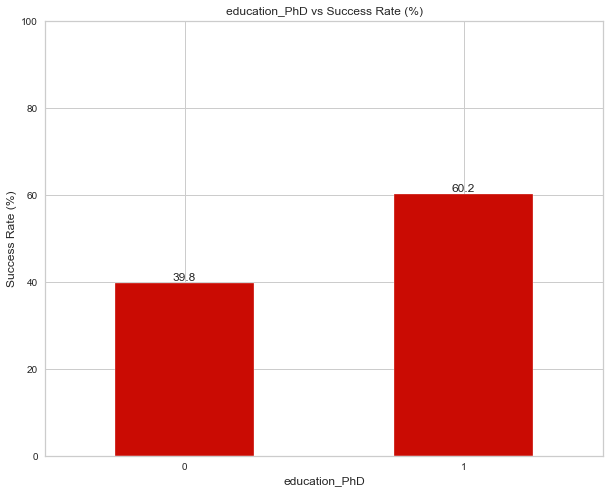

In [102]:
plot_category_category(data_new,'education_PhD','Response')

In [103]:
chi_test(data_new,'education_PhD','Response')

===== education_PhD =====
Number Expected:
[[1338.55517071  243.44482929]
 [ 371.44482929   67.55517071]]

Chi-square Statistic: 12.814301326642695, p-value: 0.0003439798382382285 less than 0.05
There is a significant difference in the target based on the predictor.



#### Observation and Conclusion

education_PhD tends to accept or response of the campaign

#### 24. Campaign vs Response

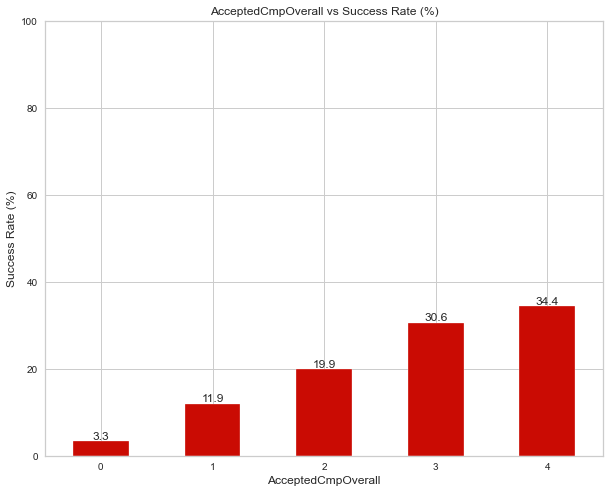

In [104]:
plot_category_category(data_new,'AcceptedCmpOverall','Response')

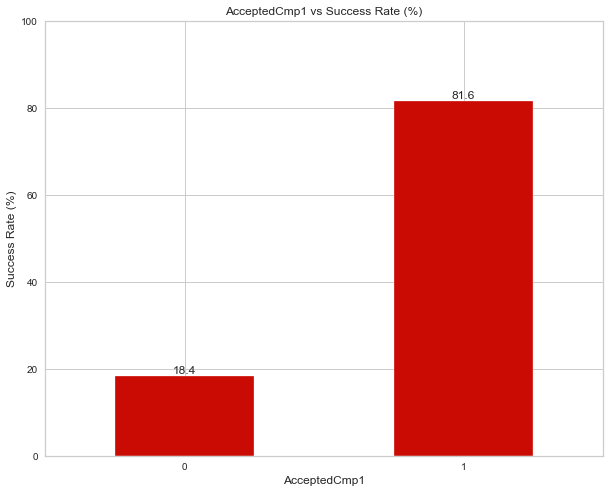

In [105]:
plot_category_category(data_new,'AcceptedCmp1','Response')

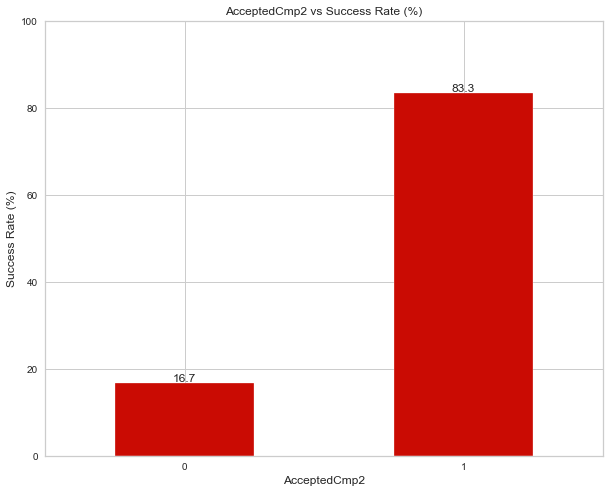

In [106]:
plot_category_category(data_new,'AcceptedCmp2','Response')

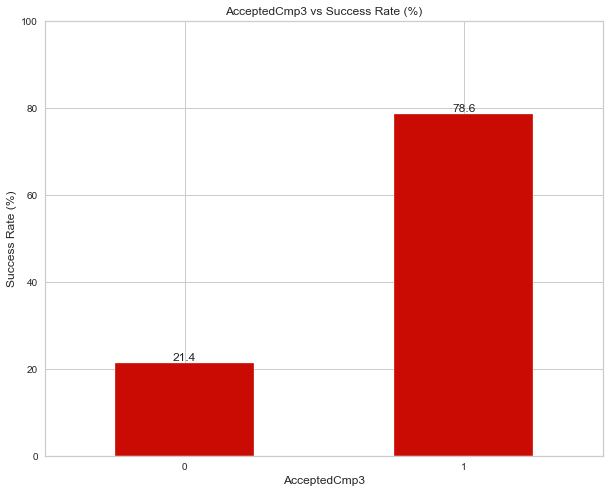

In [107]:
plot_category_category(data_new,'AcceptedCmp3','Response')

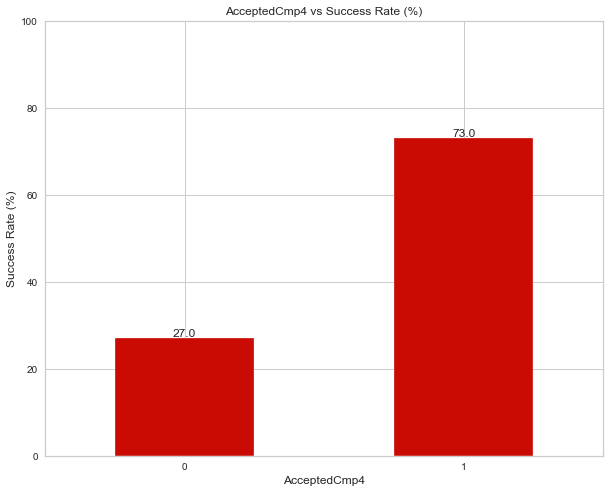

In [108]:
plot_category_category(data_new,'AcceptedCmp4','Response')

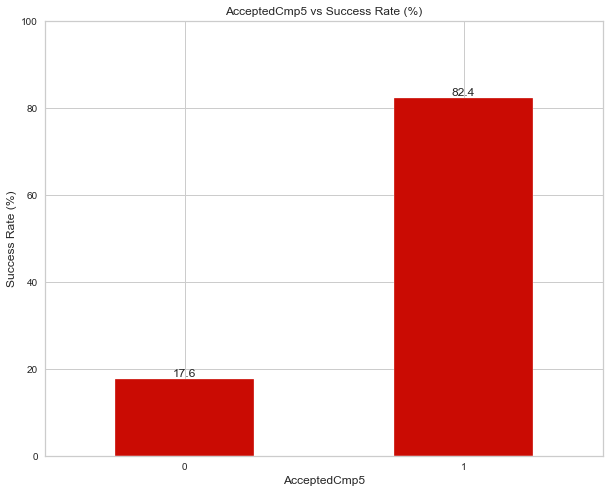

In [109]:
plot_category_category(data_new,'AcceptedCmp5','Response')

#### Observation and Conclusion

The more the costumers accept the previous campaign, the more chance they get response to the last campaign. First, second, Third, and fifth campaign seems to effect more to the last campaign

### Overall Conclusion of The Exploratory Data Analysis

1. Middle class customers (those with incomes between 53,413 and 106,827) have the highest success rate in the campaign. This suggests that targeting this income range could lead to a higher success rate in future campaigns.


2. Customers who made a purchase within the past month have the highest success rate in the campaign. This trend, known as a recency bias, suggests that targeting customers who have recently made a purchase could lead to a higher success rate in future campaigns.


3. Customers who have been enrolled in the company for over 6.5 years have the highest success rate in the campaign. This suggests that targeting more loyal, long-lasting customers could lead to a higher success rate in future campaigns.


4. Customers with an age of 25 and lower have the highest success rate in the campaign. Targeting this age range could lead to a higher success rate in future campaigns.


5. Customers with no dependencies (such as children or elderly relatives) have the highest success rate in the campaign. Targeting customers with no dependencies could lead to a higher success rate in future campaigns.


6. Customers with total purchases in the range of more than 2,000 have the highest success rate in the campaign. Targeting customers with higher spending habits could lead to a higher success rate in future campaigns.


7. Number of web purchases has a positive correlation with campaign success and a significant upward trend. Utilizing the web as a means of campaign media could lead to a higher success rate.


8. Number of deals purchased has no strong correlation with campaign success and does not have a consistent trend.


9. Number of catalog purchases has a positive correlation with campaign success and a significant upward trend. Utilizing the catalog as a means of campaign media could lead to a higher success rate.


10. Number of store purchases has no strong correlation with campaign success and does not have a consistent trend.


11. Number of web visits has no strong correlation with campaign success and does not have a consistent trend. However, there is a positive correlation between number of web purchases and campaign success, so utilizing the web for marketing campaigns could be effective.


12. Number of web visits has no strong correlation with number of web purchases and does not have a consistent trend.


13. Number of complaints in the last 2 years has no strong correlation with campaign success. Complaints do not seem to greatly affect the campaign's success.


14. Divorced customers tend to respond to or accept the campaign.


15. Married customers tend not to respond to or accept the campaign.


16. Single customers tend to respond to or accept the campaign.


17. Customers who are "together" tend not to respond to or accept the campaign.


18. Widow customers tend to respond to or accept the campaign.


19. Customers with education level of "2n Cycle" tend not to respond to or accept the campaign.


20. Customers with education level of "Basic" tend not to respond to or accept the campaign.


21. Customers with education level of "Graduation" seem to have no correlation with campaign success.


22. Customers with education level of "Master" seem to have no correlation with campaign success.


23. Customers with education level of "PhD" tend to respond to or accept the campaign.


24. The more customers accepted or responded to previous campaigns, the more likely they were to respond to the last campaign. The first, second, third, and fifth campaigns seemed to have the most impact on the last campaign.

### Recommendation of The Next Marketing Campaign

1. Target middle class customers with incomes between 53,413 and 106,827 for higher success rates.


2. Utilize recent purchases as a targeting factor, targeting customers who have made purchases within the past month.


3. Target loyal and long-lasting customers, who have been enrolled in the company for over 6.5 years.


4. Target younger customers, particularly those with an age of 25 and lower.


5. Target customers with no dependencies.


6. Target customers with higher spending, particularly those with total purchases of more than 2,000.


7. Utilize web-based marketing campaigns, as web purchases show a strong correlation with campaign success.


8. Utilize catalog-based marketing campaigns, as catalog purchases show a strong correlation with campaign success.


9. Consider targeting divorced, single, and widow customers, as they tend to respond well to campaigns.


10. Consider targeting customers who responded well to previous campaigns, particularly the first, second, third, and fifth campaigns.


11. Consider avoiding targeting married customers and those with education levels of "Basic" or "2nd Cycle", as they tend to not respond well to campaigns.

## Deep-dive Question Analysis

In [110]:
1.

1.0

## Data Preprocessing

### Splitting Data for Training and Testing ML Model

#### Changing Categorical Data to Numerical Data (rank encoding)

In [111]:
dataInfo(data_new)

========== DATA & FEATURE INFORMATION ==========
Data Rows:  2021
Data Columns:  41
Duplicated Values:  0


,Missing_val,Missing_percentage,Data_type,Unique_values
Income,0,0.0,float64,1963
Customer_Days,0,0.0,int64,662
marital_Married,0,0.0,int64,2
marital_Single,0,0.0,int64,2
marital_Together,0,0.0,int64,2
marital_Widow,0,0.0,int64,2
education_2n Cycle,0,0.0,int64,2
education_Basic,0,0.0,int64,2
education_Graduation,0,0.0,int64,2
education_Master,0,0.0,int64,2


In [112]:
data_new['Income_C'] = data_new['Income_C'].replace(['Poor or near-poor','Lower-middle class','Middle class','Upper-middle class'],[1,2,3,4])
data_new['Recency_C'] = data_new['Recency_C'].replace(['Last Two Months', 'Last Month', 'More Than Two Months'],[2,1,3])
data_new['Customer_days_C'] = data_new['Customer_days_C'].replace(['More Than 6.5 Years', 'Under 6.5 years', 'Under 6 years'],[3,2,1])
data_new['Age_C'] = data_new['Age_C'].replace(['More than 61', '46-60', '36-45', '26-35', '25 and lower'],[5,4,3,2,1])
data_new['MntTotal_C'] = data_new['MntTotal_C'].replace(['1501-2000', 'Under 500', '501-1000', '1001-1500','More Than 2000'],[4,1,2,3,5])

Most data are already one hot encoded

#### Feature Selection

Text(0.5, 1.0, 'Correlation Matrix')

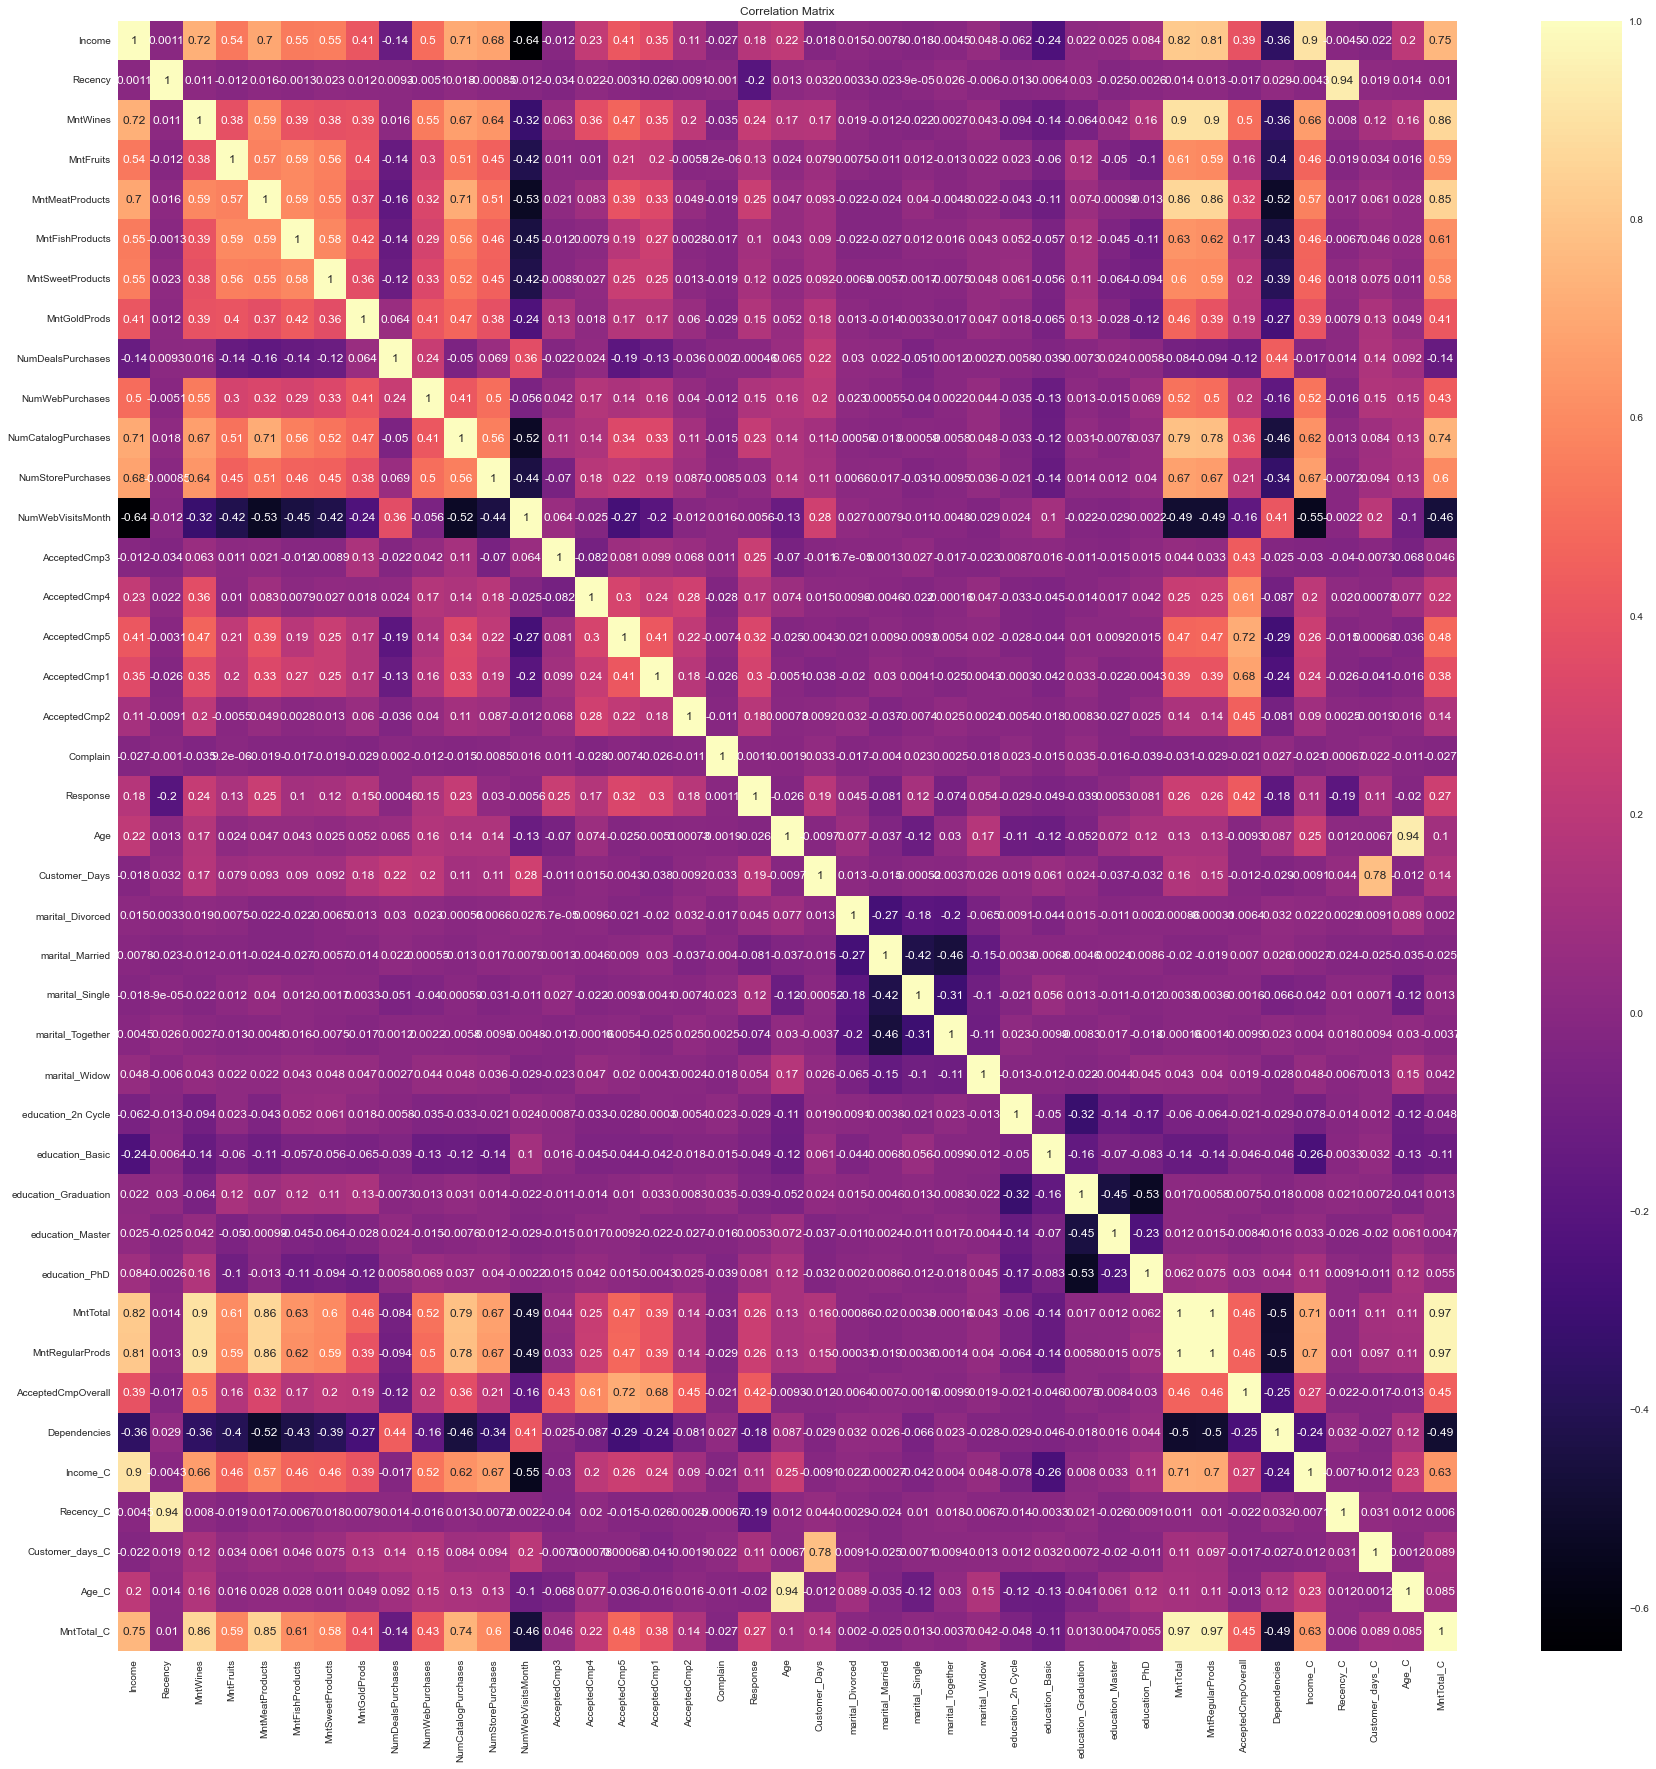

In [113]:
plt.figure(figsize=(30,30))
sns.heatmap(data_new.corr(), annot = True,
           fmt='.2g', cmap='magma')
plt.title('Correlation Matrix',fontsize = 12)

In machine learning, it is often a good idea to remove highly correlated variables (0.75 or more) because they can decrease the model's generalizability. When two or more variables are highly correlated, they provide redundant information, which can cause the model to overfit. This means that the model may perform well on the training data, but it may not generalize well to new, unseen data. By removing one of the correlated variables, you can reduce the risk of overfitting and improve the model's ability to generalize. Additionally, highly correlated variables can make it difficult to interpret the model's coefficients, as the variables may have conflicting effects on the target variable. Removing one of the correlated variables can help to clarify the relationship between the variables and the target.

#### Correlation Matrix Observation

1. Income and Income_C has 0.91. Income and Response has 0.17. Income_C and Response has 0.11. Dropping Income_C


2. Recency and Recency C has 0.94. Recency and Response has -0.2, Recency_C and Response has -0.18. Dropping Recency_C


3. Customer_Days and Customer_days_C has 0.78. Customer_Days and Response has 0.2, Customer_days_C has 0.12. Dropping customer_days_C


4. Age and Age_C has 0.94. Age and Response has 0.021. Age_C and Response has 0.016. Dropping Age_C


5. MntTotal, MntTotal_C, and MntRegularProds has 0.97. MntTotal and Response has 0.26. mntTotal_C and Response has 0.27. MntRegularProds and Response has 0.26. Dropping MntTotal and MntRegularProds


6. MntTotal_C and MntWines has 0.86. MntWines and Response has 0.24. MntTotal_C and Response has 0.27. Dropping MntWines]


7. MntTotal_C and MntMeatProducts has 0.85. MntMeatProducts and Response has 0.25. MntTotal_C and Response has 0.27. Dropping MntMeatProducts


8. MntTotal_C and Income has 0.75. Income and Response has 0.18. MntTotal_C and Response has 0.27. Dropping Income

In [114]:
data_new_ML = data_new.copy()

data_new_ML = data_new_ML.drop(['Income_C','Recency_C','Customer_days_C','Age_C','MntTotal', 'MntRegularProds', 'MntWines','MntMeatProducts','Income'],axis = 1)

#### Splitting Data

In [115]:
X = data_new_ML.drop('Response',axis=1).copy()
y = data_new_ML['Response'].copy()

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=69)

## Machine Learning Model, Evaluation, Feature Importance

### Machine Learning Function

In [116]:
def evaluate_train(X, y, model):
    model.fit(X, y)
    prediction = model.predict(X)
    cm = confusion_matrix(y, prediction, labels=model.classes_)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

    print(f'Recall Score: {recall_score(y, prediction)}')
    print(f'Precision Score: {precision_score(y, prediction)}')
    print(f'F1 Score: {f1_score(y, prediction)}')
    print(f'ROC-AUC Score: {roc_auc_score(y, model.predict_proba(X)[:, 1])}')

    display.plot()

In [117]:
def evaluate_test(X, y, model, labels=None):
    if labels is None:
        labels = model.classes_
    
    prediction = model.predict(X)
    cm = confusion_matrix(y, prediction, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    print(f'Recall Score: {recall_score(y, prediction)}')
    print(f'Precision Score: {precision_score(y, prediction)}')
    print(f'F1 Score: {f1_score(y, prediction)}')
    print(f'ROC-AUC Score: {roc_auc_score(y, model.predict_proba(X)[:, 1])}')
    
    disp.plot()

### Model and Evaluation

#### Logistic Regression

In [118]:
logreg_model = LogisticRegression(random_state=69,class_weight='balance')

Recall Score: 0.22641509433962265
Precision Score: 0.5714285714285714
F1 Score: 0.3243243243243244
ROC-AUC Score: 0.8283893981728566


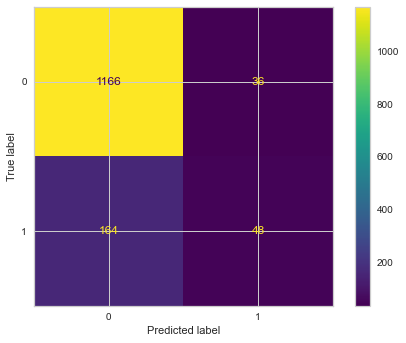

In [119]:
evaluate_train(X_train,y_train,logreg_model)

Recall Score: 0.32323232323232326
Precision Score: 0.5714285714285714
F1 Score: 0.4129032258064516
ROC-AUC Score: 0.7837827089795594


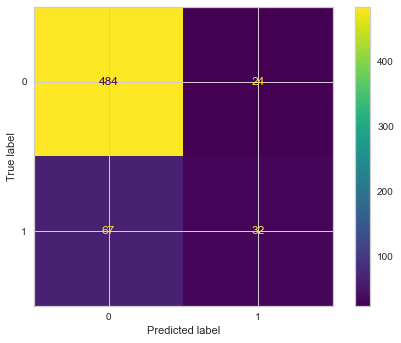

In [120]:
evaluate_test(X_test,y_test,logreg_model)

#### KNN

In [121]:
knn_model = KNeighborsClassifier()

Recall Score: 0.2641509433962264
Precision Score: 0.7088607594936709
F1 Score: 0.3848797250859107
ROC-AUC Score: 0.8840081781935767


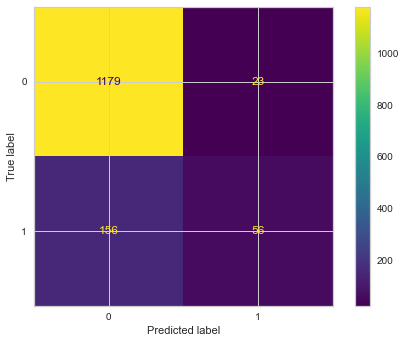

In [122]:
evaluate_train(X_train,y_train,knn_model)

Recall Score: 0.04040404040404041
Precision Score: 0.16666666666666666
F1 Score: 0.06504065040650407
ROC-AUC Score: 0.5821502425833134


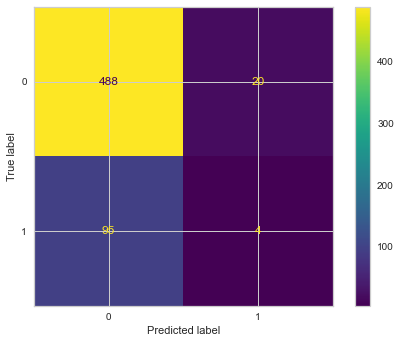

In [123]:
evaluate_test(X_test,y_test,knn_model)

#### Naive Bayes

In [124]:
naive = GaussianNB()

Recall Score: 0.589622641509434
Precision Score: 0.4528985507246377
F1 Score: 0.5122950819672132
ROC-AUC Score: 0.8058130317395535


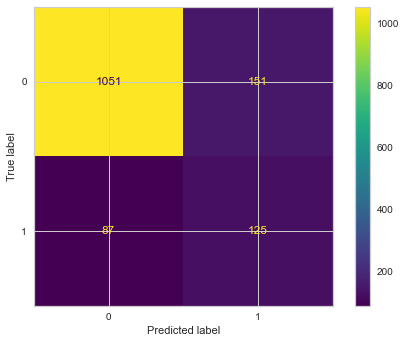

In [125]:
evaluate_train(X_train,y_train,naive)

Recall Score: 0.6868686868686869
Precision Score: 0.4171779141104294
F1 Score: 0.5190839694656488
ROC-AUC Score: 0.8117990932951562


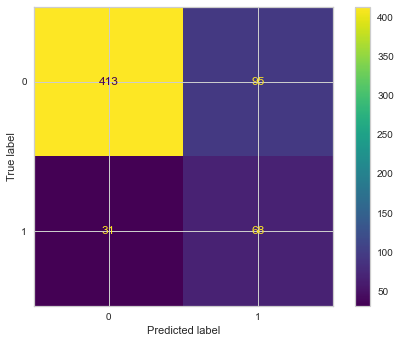

In [126]:
evaluate_train(X_test,y_test,naive)

#### Decision Tree

In [127]:
dt = DecisionTreeClassifier(random_state=69)

Recall Score: 0.9433962264150944
Precision Score: 1.0
F1 Score: 0.970873786407767
ROC-AUC Score: 0.9997174520453332


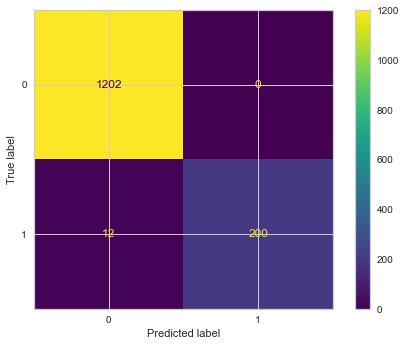

In [128]:
evaluate_train(X_train,y_train,dt)

Recall Score: 0.48484848484848486
Precision Score: 0.4444444444444444
F1 Score: 0.463768115942029
ROC-AUC Score: 0.6852879185556351


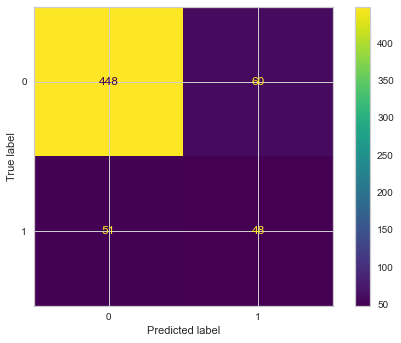

In [129]:
evaluate_test(X_test,y_test,dt)

#### Random Forest

In [130]:
rf = RandomForestClassifier(random_state=69)

Recall Score: 0.9528301886792453
Precision Score: 0.9901960784313726
F1 Score: 0.9711538461538463
ROC-AUC Score: 0.9997135277681851


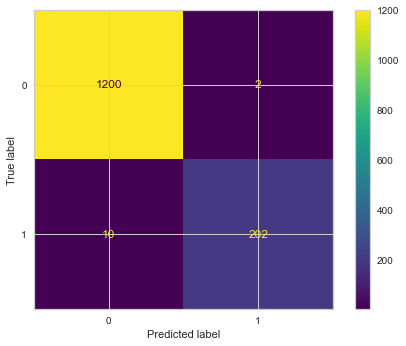

In [131]:
evaluate_train(X_train,y_train,rf)

Recall Score: 0.3434343434343434
Precision Score: 0.6938775510204082
F1 Score: 0.4594594594594595
ROC-AUC Score: 0.8523522627853337


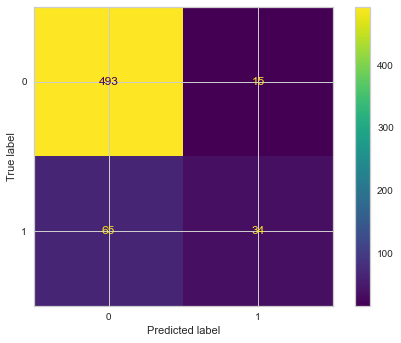

In [132]:
evaluate_test(X_test,y_test,rf)

In [133]:
parameters = {
'n_estimators' : (100, 300, 500, 600, 800),
'max_depth' : (5, 8,10, 15 ,20, 25, 30),
'min_samples_split' : (2, 5, 10, 15, 100),
'min_samples_leaf' : (1, 2, 5, 10,20,30)
}

gridF = RandomizedSearchCV(rf, parameters, cv =5, verbose = 1, 
                           n_iter=10)
bestF = gridF.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Recall Score: 0.46226415094339623
Precision Score: 0.9607843137254902
F1 Score: 0.6242038216560509
ROC-AUC Score: 0.9749199447461778


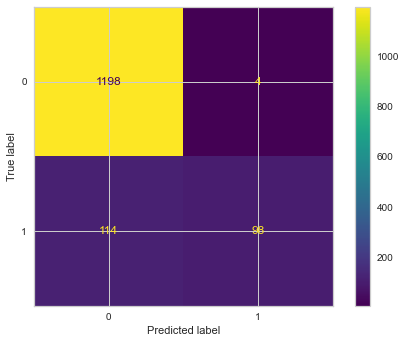

In [134]:
evaluate_test(X_train,y_train,bestF)

Recall Score: 0.3434343434343434
Precision Score: 0.7555555555555555
F1 Score: 0.47222222222222215
ROC-AUC Score: 0.8485047323630001


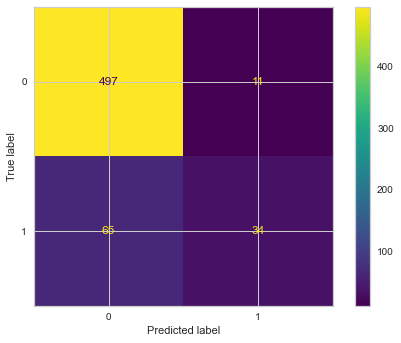

In [135]:
evaluate_test(X_test,y_test,bestF)

## Final Conclusion and Suggestion

### Model Prediction

The Random Forest model was able to predict 75% of customers who responded to the marketing campaign out of all the customers predicted to respond. Overall, the model has a high level of accuracy in predicting customer responses to the marketing campaign.

### Campaign Recommendation

Based on the data analyzed, it is recommended to target middle class customers with incomes between 53,413 and 106,827 for higher success rates in marketing campaigns. Additionally, utilizing recent purchases as a targeting factor and targeting loyal and long-lasting customers may also lead to higher success rates. Younger customers, particularly those with an age of 25 and lower, and customers with no dependencies should also be targeted for higher success rates. To increase success, focus on targeting customers with higher spending, particularly those with total purchases of more than 2,000. Utilizing web-based and catalog-based marketing campaigns may also lead to higher success rates, as these types of purchases show a strong correlation with campaign success. In terms of customer demographics, consider targeting divorced, single, and widow customers as they tend to respond well to campaigns. It is also recommended to target customers who responded well to previous campaigns, particularly the first, second, third, and fifth campaigns. On the other hand, it may be wise to avoid targeting married customers and those with education levels of "Basic" or "2nd Cycle", as they tend to not respond well to campaigns.

### Campaign Form

1. Identify the target audience for the campaign: middle class customers with incomes between 53,413 and 106,827, recent purchasers, loyal and long-lasting customers, younger customers with an age of 25 and lower, customers with no dependencies, and customers with high spending (total purchases of more than 2,000).


2. Determine the channels to be used for the campaign: web and catalog.


3. Create marketing materials and campaigns that are tailored to the identified target audience and channels. This may include targeted email campaigns, personalized catalogs, and targeted advertisements on the company's website.


4. Monitor the performance of the campaigns and make adjustments as needed. This may include testing different targeting methods and adjusting the content of the marketing materials.


5. Analyze the results of the campaigns to determine their effectiveness and identify areas for improvement.


6. Repeat the campaign process with any necessary adjustments based on the results of previous campaigns.



### Campaign Example

Campaign Name: "Personalized Shopping Experience for Middle Class Customers"

Campaign Date: January 1st, 2023 - December 31st, 2023

Target Audience: middle class customers with incomes between 53,413 and 106,827, recent purchasers, loyal and long-lasting customers, younger customers with an age of 25 and lower, customers with no dependencies, and customers with high spending (total purchases of more than 2,000)

Channels: web and catalog

Marketing Materials and Campaigns:

Targeted email campaigns: send personalized emails to the target audience with product recommendations based on their past purchases and browsing history.
Personalized catalogs: create catalogs with product selections tailored to the interests of the target audience.
Targeted advertisements on the company's website: use data on the target audience's browsing history and interests to display personalized ads when they visit the company's website.
Monitoring and Adjustments:

Monitor the performance of the campaigns through metrics such as click-through rate and conversion rate.
Test different targeting methods, such as segmenting the target audience by age or income, to see which methods are most effective.
Adjust the content of the marketing materials based on the performance of the campaigns and feedback from the target audience.
Analysis and Improvement:

Analyze the results of the campaigns to determine their effectiveness, using metrics such as sales revenue and customer satisfaction.
Identify areas for improvement, such as underperforming marketing materials or channels, and make necessary adjustments for future campaigns.
Repeating the Campaign Process:

Based on the results of the previous campaigns, repeat the campaign process with any necessary adjustments to target audience, channels, marketing materials, and tactics.